<a href="https://colab.research.google.com/github/bpareshgit/code_snippets/blob/master/Forcasting_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ideal version for this code is tensorflow 2.6.0 

!pip install pmdarima
!pip install keras==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 9.7 MB/s 
     |████████████████████████████████| 9.8 MB 42.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.6.0 which is incompatible.


In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_ts = pd.read_csv("drive/MyDrive/Thesis/Code/time_series_60min_singleindex.csv", parse_dates=['utc_timestamp'])
data_ts["utc_timestamp"] = pd.to_datetime(data_ts["utc_timestamp"])
data_ts



# data_ts = pd.read_csv("time_series_60min_singleindex.csv", parse_dates=['utc_timestamp'])
# data_ts["utc_timestamp"] = pd.to_datetime(data_ts["utc_timestamp"])
# data_ts

utc_timestamp        cet_cest_timestamp  \
0     2014-12-31 23:00:00+00:00  2015-01-01T00:00:00+0100   
1     2015-01-01 00:00:00+00:00  2015-01-01T01:00:00+0100   
2     2015-01-01 01:00:00+00:00  2015-01-01T02:00:00+0100   
3     2015-01-01 02:00:00+00:00  2015-01-01T03:00:00+0100   
4     2015-01-01 03:00:00+00:00  2015-01-01T04:00:00+0100   
...                         ...                       ...   
50396 2020-09-30 19:00:00+00:00  2020-09-30T21:00:00+0200   
50397 2020-09-30 20:00:00+00:00  2020-09-30T22:00:00+0200   
50398 2020-09-30 21:00:00+00:00  2020-09-30T23:00:00+0200   
50399 2020-09-30 22:00:00+00:00  2020-10-01T00:00:00+0200   
50400 2020-09-30 23:00:00+00:00  2020-10-01T01:00:00+0200   

       AT_load_actual_entsoe_transparency  \
0                                     NaN   
1                                  5946.0   
2                                  5726.0   
3                                  5347.0   
4                                  5249.0   
...                                   ...   
50396                              6661.0   
50397                              6336.0   
50398                              5932.0   
50399                              5628.0   
50400                              5395.0   

       AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
0                                       NaN                 NaN   
1                                    6701.0                35.0   
2                                    6593.0                45.0   
3                                    6482.0                41.0   
4                                    6454.0                38.0   
...                                     ...                 ...   
50396                                6656.0                 NaN   
50397                                6310.0                 NaN   
50398                                5813.0                 NaN   
50399                                5424.0                 NaN   
50400                                5204.0                 NaN   

       AT_solar_generation_actual  AT_wind_onshore_generation_actual  \
0                             NaN                                NaN   
1                             NaN                               69.0   
2                             NaN                               64.0   
3                             NaN                               65.0   
4                             NaN                               64.0   
...                           ...                                ...   
50396                         NaN                             1847.0   
50397                         NaN                             1723.0   
50398                         NaN                             1771.0   
50399                         NaN                             1779.0   
50400                         NaN                             1661.0   

       BE_load_actual_entsoe_transparency  \
0                                     NaN   
1                                  9484.0   
2                                  9152.0   
3                                  8799.0   
4                                  8567.0   
...                                   ...   
50396                              9402.0   
50397                              9219.0   
50398                              8763.0   
50399                              8131.0   
50400                              7837.0   

       BE_load_forecast_entsoe_transparency  BE_solar_generation_actual  ...  \
0                                       NaN                         NaN  ...   
1                                    9897.0                         NaN  ...   
2                                    9521.0                         NaN  ...   
3                                    9135.0                         NaN  ...   
4                                    8909.0                         NaN  ...   
...                                     ...          

In [ ]:
data_w = pd.read_csv("drive/MyDrive/Thesis/Code/weather_data.csv", parse_dates=['utc_timestamp'])
data_w["utc_timestamp"] = pd.to_datetime(data_w["utc_timestamp"])
data_w

utc_timestamp  AT_temperature  \
0      1980-01-01 00:00:00+00:00          -3.640   
1      1980-01-01 01:00:00+00:00          -3.803   
2      1980-01-01 02:00:00+00:00          -3.969   
3      1980-01-01 03:00:00+00:00          -4.076   
4      1980-01-01 04:00:00+00:00          -4.248   
...                          ...             ...   
350635 2019-12-31 19:00:00+00:00          -1.386   
350636 2019-12-31 20:00:00+00:00          -1.661   
350637 2019-12-31 21:00:00+00:00          -1.986   
350638 2019-12-31 22:00:00+00:00          -2.184   
350639 2019-12-31 23:00:00+00:00          -2.271   

        AT_radiation_direct_horizontal  AT_radiation_diffuse_horizontal  \
0                                  0.0                              0.0   
1                                  0.0                              0.0   
2                                  0.0                              0.0   
3                                  0.0                              0.0   
4                                  0.0                              0.0   
...                                ...                              ...   
350635                             0.0                              0.0   
350636                             0.0                              0.0   
350637                             0.0                              0.0   
350638                             0.0                              0.0   
350639                             0.0                              0.0   

        BE_temperature  BE_radiation_direct_horizontal  \
0               -0.720                             0.0   
1               -1.165                             0.0   
2               -1.434                             0.0   
3               -1.843                             0.0   
4               -2.094                             0.0   
...                ...                             ...   
350635           1.684                             0.0   
350636           1.718                             0.0   
350637           1.726                             0.0   
350638           1.569                             0.0   
350639           1.216                             0.0   

        BE_radiation_diffuse_horizontal  BG_temperature  \
0                                   0.0           4.664   
1                                   0.0           4.052   
2                                   0.0           3.581   
3                                   0.0           3.197   
4                                   0.0           2.750   
...                                 ...             ...   
350635                              0.0          -1.351   
350636                              0.0          -1.009   
350637                              0.0          -0.986   
350638                              0.0          -1.270   
350639                              0.0          -1.826   

        BG_radiation_direct_horizontal  BG_radiation_diffuse_horizontal  ...  \
0                                  0.0                              0.0  ...   
1                                  0.0                              0.0  ...   
2                                  0.0                              0.0  ...   
3                                  0.0                              0.0  ...   
4                                  0.0                              0.0  ...   
...                                ...                              ...  ...   
350635                             0.0                              0.0  ...   
350636                             0.0                              0.0  ...   
350637                             0.0                              0.0  ...   
350638                             0.0                              0.0  ...   
350639                             0.0                              0.0  ...   

        RO_radiation_diffuse_horizontal  SE_temperature  \
0                                   0.0          -3.945   
1       

Resample dataset to be daily instead of hourly because the dataset is too noisy

In [ ]:
vars = ["utc_timestamp", 'DE_wind_capacity',"DE_wind_generation_actual", "DE_wind_offshore_capacity", "DE_wind_offshore_generation_actual","DE_wind_onshore_capacity","DE_wind_onshore_generation_actual"]

In [ ]:
vars2 = ['utc_timestamp','DE_temperature']

In [ ]:
data_ts2 = data_ts[vars]
data_w2 = data_w[vars2]

In [ ]:
data_ts3 = data_ts2.resample('24H', on = 'utc_timestamp').agg({"DE_wind_generation_actual":np.sum,
                                                       'DE_wind_capacity': np.mean,
                                                       "DE_wind_offshore_capacity":np.mean, 
                                                       "DE_wind_offshore_generation_actual":np.sum,
                                                       "DE_wind_onshore_capacity":np.mean,
                                                       "DE_wind_onshore_generation_actual":np.sum                                                       
                                                       })

#data_ts3["utc_timestamp"] = data_ts3.index
data_ts3 = data_ts3.reset_index()
#data_ts3  = data_ts3.drop(['utc_timestamp'], axis = 1)

In [ ]:
data_w3 = data_w2.resample('24H', on = 'utc_timestamp').agg({"DE_temperature":np.mean})
data_w3 = data_w3.reset_index()
#data_w3["utc_timestamp"] = data_w3.index
#data_w3  = data_w3.drop(['utc_timestamp'], axis = 1)

In [ ]:
data = pd.merge(data_ts3,data_w3, on = "utc_timestamp")
cols = []
for col in data.columns:
  if col != "utc_timestamp":
    cols.append(col[3:])
  else:
    cols.append("utc_timestamp")
data.columns = cols
data

utc_timestamp  wind_generation_actual  wind_capacity  \
0    2014-12-31 00:00:00+00:00                     0.0   27913.000000   
1    2015-01-01 00:00:00+00:00                325165.0   27913.541667   
2    2015-01-02 00:00:00+00:00                603554.0   27926.000000   
3    2015-01-03 00:00:00+00:00                462955.0   27926.000000   
4    2015-01-04 00:00:00+00:00                385023.0   27926.541667   
...                        ...                     ...            ...   
1822 2019-12-27 00:00:00+00:00                146590.0   50427.000000   
1823 2019-12-28 00:00:00+00:00                159126.0   50427.291667   
1824 2019-12-29 00:00:00+00:00                349839.0   50434.750000   
1825 2019-12-30 00:00:00+00:00                669271.0   50452.000000   
1826 2019-12-31 00:00:00+00:00                425225.0            NaN   

      wind_offshore_capacity  wind_offshore_generation_actual  \
0                 667.000000                              0.0   
1                 667.000000                          12297.0   
2                 667.000000                          10533.0   
3                 667.000000                          12125.0   
4                 667.125000                          11500.0   
...                      ...                              ...   
1822             5735.000000                          40135.0   
1823             5735.291667                          66626.0   
1824             5742.000000                         121886.0   
1825             5742.000000                         133426.0   
1826                     NaN                          81593.0   

      wind_onshore_capacity  wind_onshore_generation_actual  temperature  
0              27246.000000                             0.0    -0.057542  
1              27246.541667                        312868.0    -0.295958  
2              27259.000000                        593022.0     1.619958  
3              27259.000000                        450829.0     0.851458  
4              27259.375000                        373525.0     0.493625  
...                     ...                             ...          ...  
1822           44692.000000                        106453.0     1.327167  
1823           44692.000000                         92505.0    -1.441167  
1824           44692.750000                        227954.0    -1.314500  
1825           44710.000000                        535847.0     0.510208  
1826                    NaN                        343630.0     1.418833  

[1827 rows x 8 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 1826
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   utc_timestamp                    1827 non-null   datetime64[ns, UTC]
 1   wind_generation_actual           1827 non-null   float64            
 2   wind_capacity                    1826 non-null   float64            
 3   wind_offshore_capacity           1826 non-null   float64            
 4   wind_offshore_generation_actual  1827 non-null   float64            
 5   wind_onshore_capacity            1826 non-null   float64            
 6   wind_onshore_generation_actual   1827 non-null   float64            
 7   temperature                      1827 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 128.5 KB


we have missing data

In [ ]:
data.isnull().sum()*100 / data.shape[0]

NameError: ignored

In [ ]:
data.isna().sum()

utc_timestamp                      0
wind_generation_actual             0
wind_capacity                      1
wind_offshore_capacity             1
wind_offshore_generation_actual    0
wind_onshore_capacity              1
wind_onshore_generation_actual     0
temperature                        0
dtype: int64

In [ ]:
data = data.fillna(0)
data.isna().sum()

utc_timestamp                      0
wind_generation_actual             0
wind_capacity                      0
wind_offshore_capacity             0
wind_offshore_generation_actual    0
wind_onshore_capacity              0
wind_onshore_generation_actual     0
temperature                        0
dtype: int64

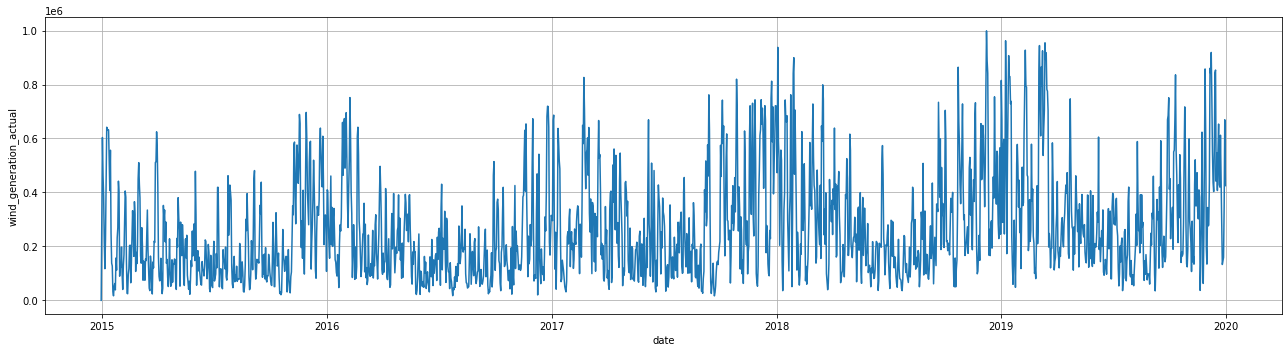

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))
#one_year = data[(data["utc_timestamp"] > '2018-12-30 22:00:00+00:00') & (data["utc_timestamp"] <= '2019-12-30 22:00:00+00:00')]
ax.plot( (data["utc_timestamp"]), data["wind_generation_actual"])
ax.grid()
ax.set_ylabel("wind_generation_actual")
ax.set_xlabel('date')
fig.tight_layout()
plt.show()

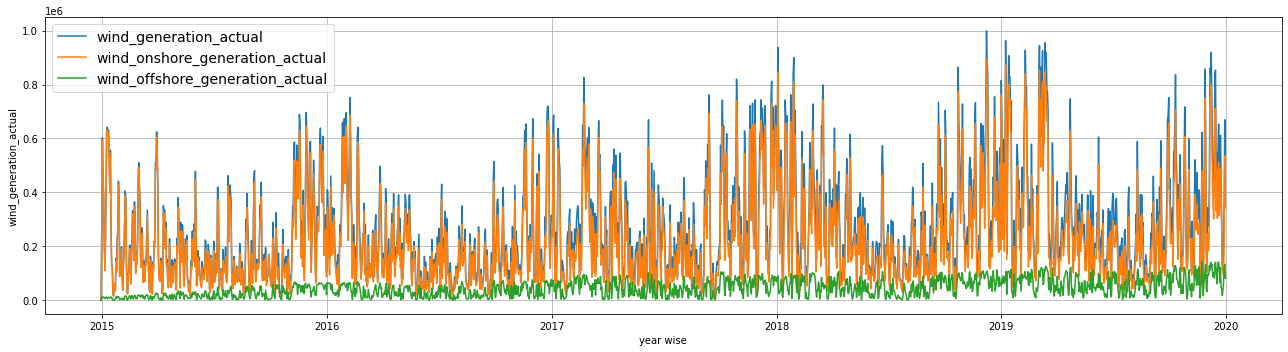

In [ ]:
fig, axs = plt.subplots(figsize=(18, 5))

Wind_generation_actual=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual"])
Wind_generation_onshore=axs.plot( (data["utc_timestamp"]), data["wind_onshore_generation_actual"])
Wind_generation_offshore=axs.plot( (data["utc_timestamp"]), data["wind_offshore_generation_actual"])
axs.grid()
axs.set_ylabel("wind_generation_actual")
axs.set_xlabel('year wise')
plt.legend(labels =['wind_generation_actual', 'wind_onshore_generation_actual', 'wind_offshore_generation_actual'], fontsize=14)
fig.tight_layout()
plt.show()

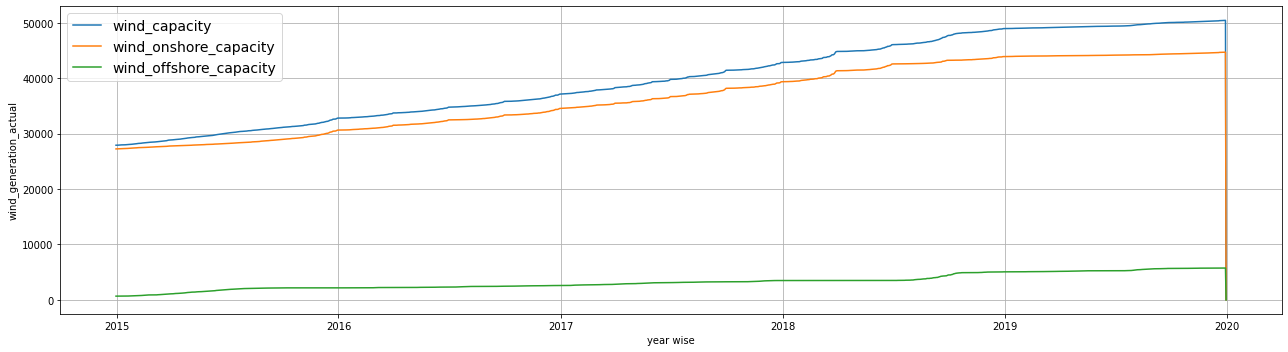

In [ ]:
fig, axs = plt.subplots(figsize=(18, 5))

Wind_generation_actual=axs.plot( (data["utc_timestamp"]), data["wind_capacity"])
Wind_generation_onshore=axs.plot( (data["utc_timestamp"]), data["wind_onshore_capacity"])
Wind_generation_offshore=axs.plot( (data["utc_timestamp"]), data["wind_offshore_capacity"])
axs.grid()
axs.set_ylabel("wind_generation_actual")
axs.set_xlabel('year wise')
plt.legend(labels =['wind_capacity', 'wind_onshore_capacity', 'wind_offshore_capacity'], fontsize=14)
fig.tight_layout()
plt.show()

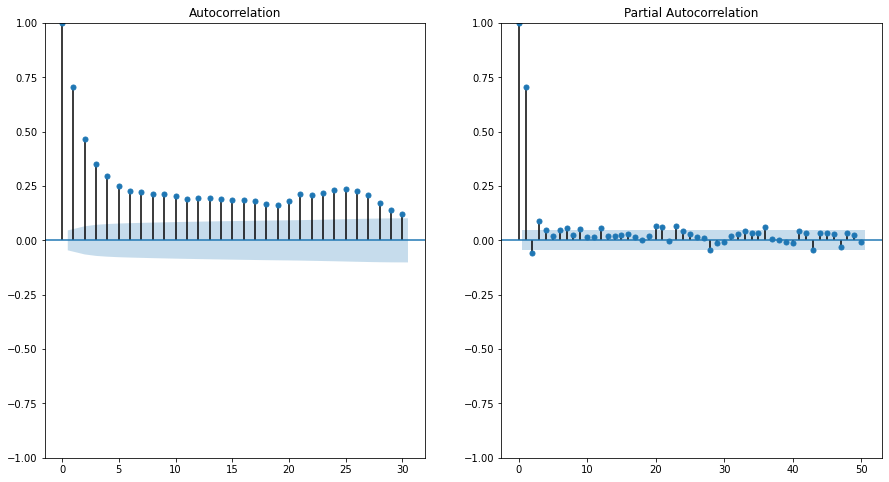

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
acf_plot = plot_acf(data['wind_generation_actual'], lags=30, ax = ax[0])
pacf_plot = plot_pacf(data["wind_generation_actual"], lags=50, ax = ax[1])
plt.show()

plots: determine the ARIMAX(p,d,q) model parameters where p is determined by acf plot and q is determined by partial acf plot and also help in feature engineering

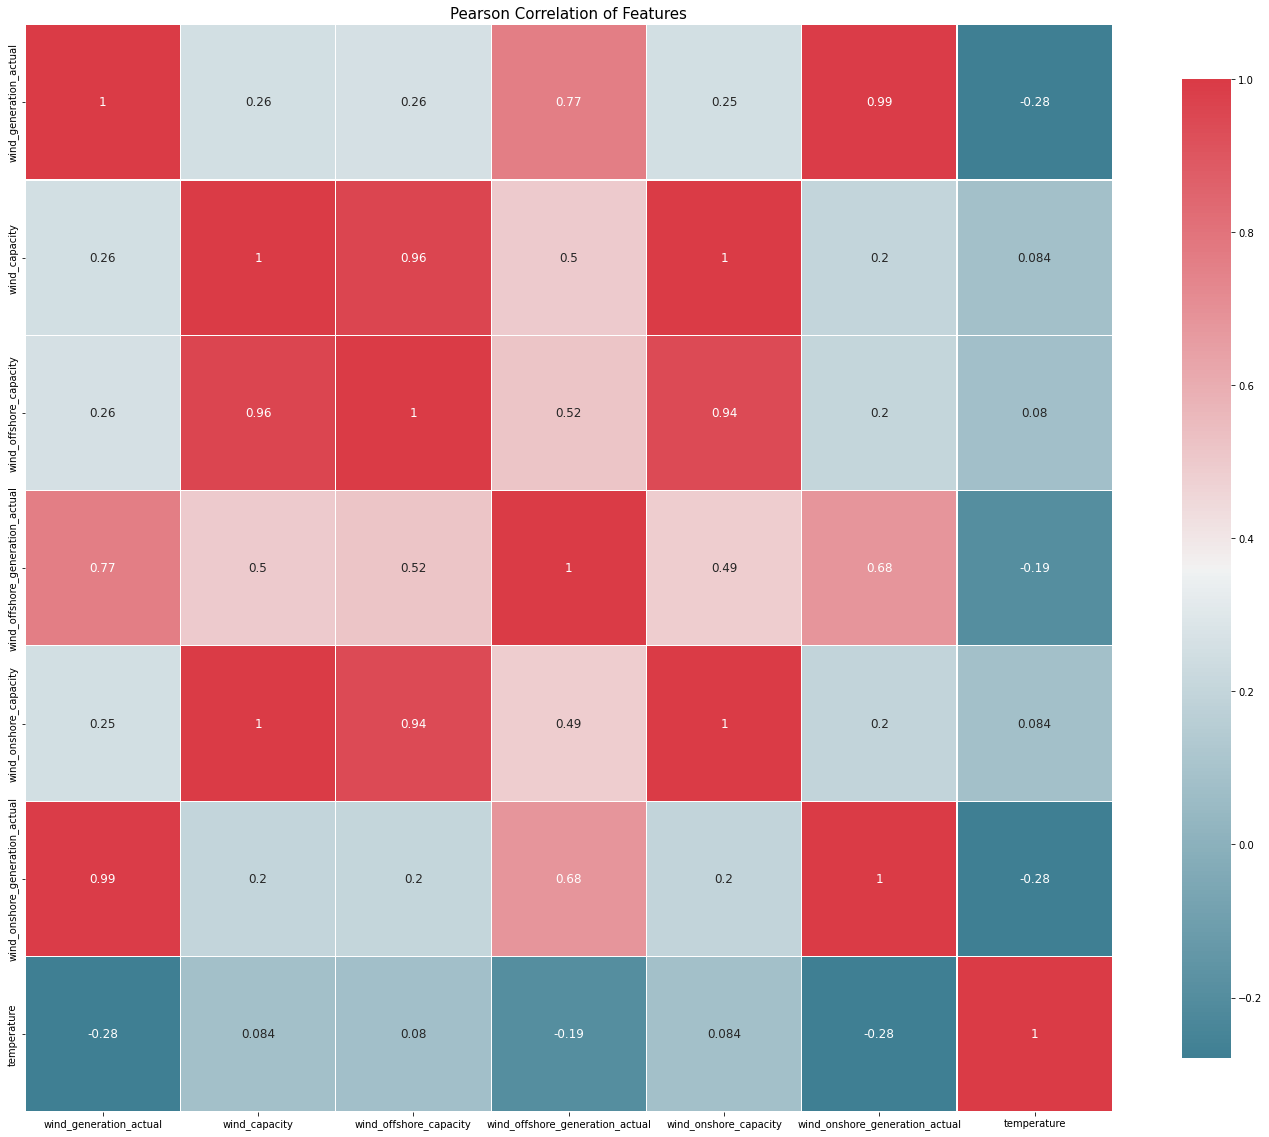

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(25, 20))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)

# Feature engineering
+https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114


create new features such as year or month and shifted versions of original features (lag features)
+https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/#:~:text=the%20next%20section.-,Lag%20Features,transformed%20into%20supervised%20learning%20problems.&text=The%20Pandas%20library%20provides%20the,from%20a%20time%20series%20dataset.
Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The Pandas library provides the shift() function to help create these shifted or lag features from a time series dataset.

In [ ]:
def feature_engineering(data):
    
    data["utc_timestamp"] = pd.to_datetime(data["utc_timestamp"], format="%Y-%m-%d")
    data["year"] = data["utc_timestamp"].dt.year
    data["month"] = data["utc_timestamp"].dt.month
    
    lag_features = ['wind_generation_actual', 'wind_onshore_generation_actual', 'wind_offshore_generation_actual','wind_capacity', 'wind_onshore_capacity', 'wind_offshore_capacity','temperature']
    window1 = 2
    window2 = 3
    window3 = 7

    data_rolled_2d = data[lag_features].rolling(window=window1, min_periods=0)
    data_rolled_3d = data[lag_features].rolling(window=window2, min_periods=0)
    data_rolled_7d = data[lag_features].rolling(window=window3, min_periods=0)

    #mean  of all  
    data_mean_2d = data_rolled_2d.mean().shift(1)
    data_mean_3d = data_rolled_3d.mean().shift(1)
    data_mean_7d = data_rolled_7d.mean().shift(1)
    
    #std of all 
    data_std_2d = data_rolled_2d.std().shift(1)
    data_std_3d = data_rolled_3d.std().shift(1)
    data_std_7d = data_rolled_7d.std().shift(1)
    

    #loop for implimentation 
    for feature in lag_features:
        data[f"{feature}_mean_lag{window1}"] = data_mean_2d[feature]
        data[f"{feature}_mean_lag{window2}"] = data_mean_3d[feature]
        data[f"{feature}_mean_lag{window3}"] = data_mean_7d[feature]

        data[f"{feature}_std_lag{window1}"] = data_std_2d[feature]
        data[f"{feature}_std_lag{window2}"] = data_std_3d[feature]
        data[f"{feature}_std_lag{window3}"] = data_std_7d[feature]

    data.fillna(data.mean(), inplace=True)
    
feature_engineering(data)

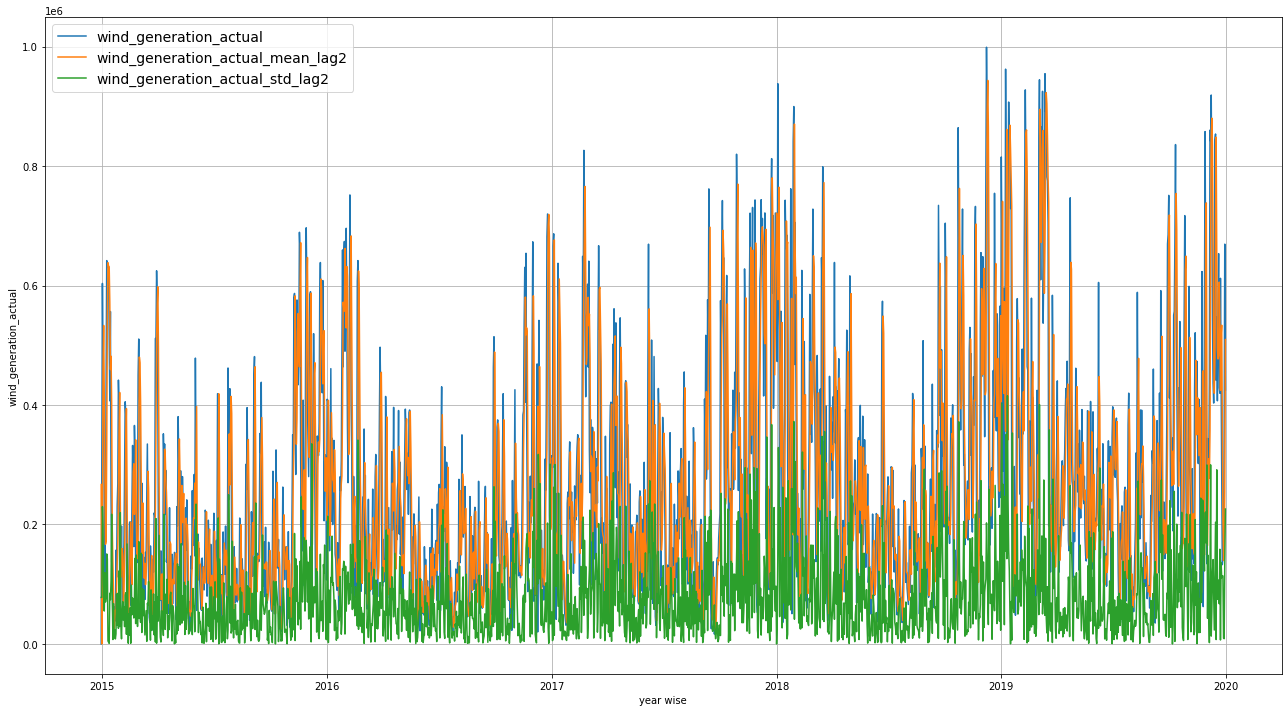

In [ ]:
fig, axs = plt.subplots(figsize=(18, 10))

Wind_generation_actual=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual"])
Wind_generation_onshore=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual_mean_lag2"])
Wind_generation_offshore=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual_std_lag2"])
axs.grid()
axs.set_ylabel("wind_generation_actual")
axs.set_xlabel('year wise')
plt.legend(labels =['wind_generation_actual', 'wind_generation_actual_mean_lag2', 'wind_generation_actual_std_lag2'], fontsize=14)
fig.tight_layout()
plt.show()

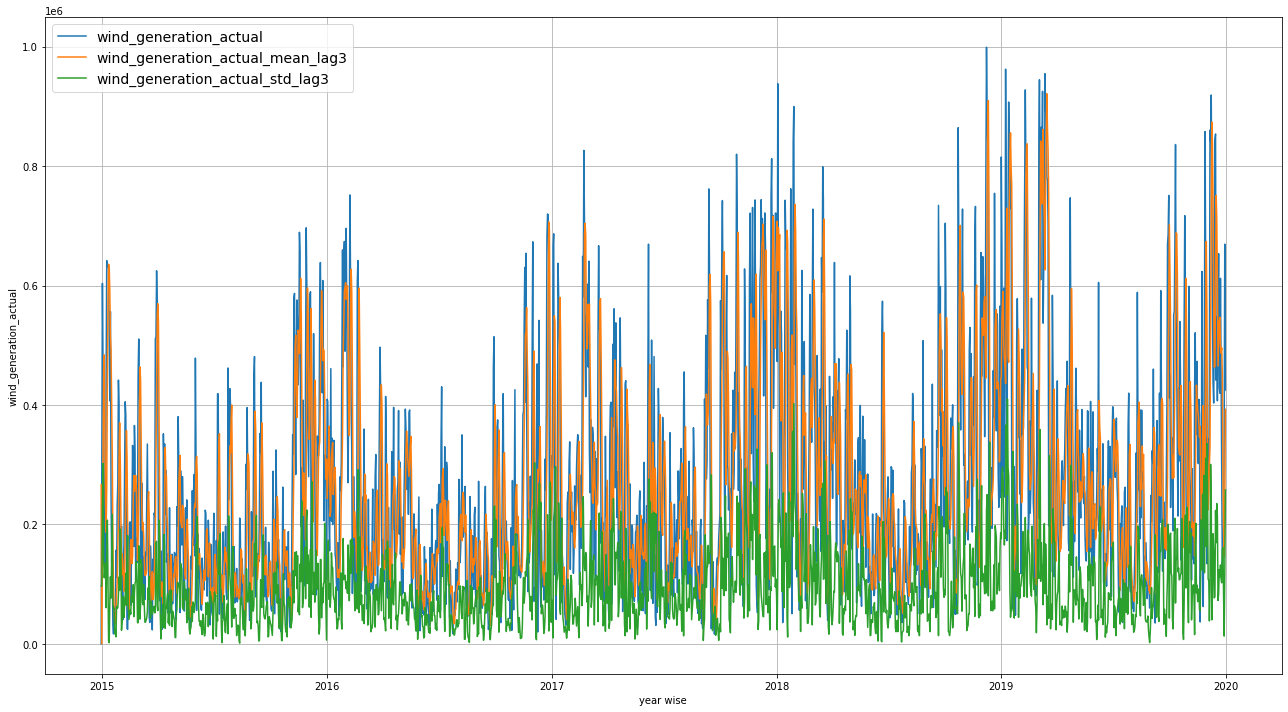

In [ ]:
fig, axs = plt.subplots(figsize=(18, 10))

Wind_generation_actual=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual"])
Wind_generation_onshore=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual_mean_lag3"])
Wind_generation_offshore=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual_std_lag3"])
axs.grid()
axs.set_ylabel("wind_generation_actual")
axs.set_xlabel('year wise')
plt.legend(labels =['wind_generation_actual', 'wind_generation_actual_mean_lag3', 'wind_generation_actual_std_lag3'], fontsize=14)
fig.tight_layout()
plt.show()

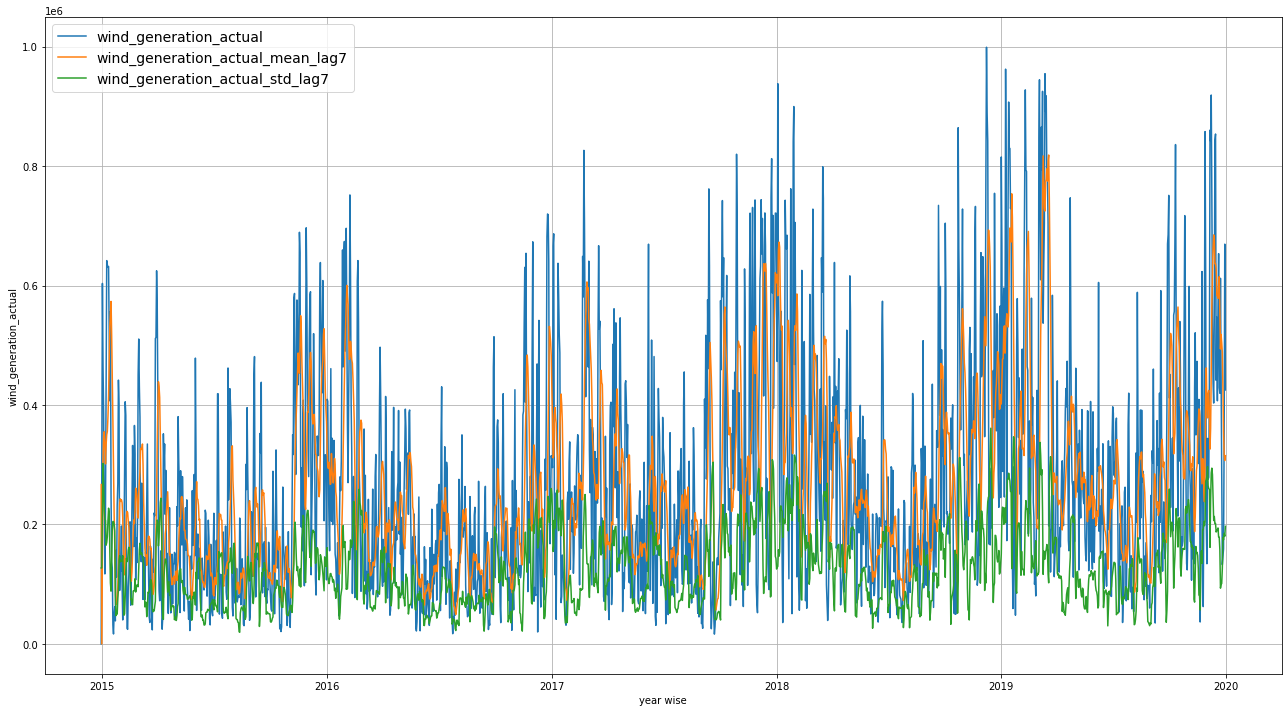

In [ ]:
fig, axs = plt.subplots(figsize=(18, 10))

Wind_generation_actual=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual"])
Wind_generation_onshore=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual_mean_lag7"])
Wind_generation_offshore=axs.plot( (data["utc_timestamp"]), data["wind_generation_actual_std_lag7"])
axs.grid()
axs.set_ylabel("wind_generation_actual")
axs.set_xlabel('year wise')
plt.legend(labels =['wind_generation_actual', 'wind_generation_actual_mean_lag7', 'wind_generation_actual_std_lag7'], fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
data

utc_timestamp  wind_generation_actual  wind_capacity  \
0    2014-12-31 00:00:00+00:00                     0.0   27913.000000   
1    2015-01-01 00:00:00+00:00                325165.0   27913.541667   
2    2015-01-02 00:00:00+00:00                603554.0   27926.000000   
3    2015-01-03 00:00:00+00:00                462955.0   27926.000000   
4    2015-01-04 00:00:00+00:00                385023.0   27926.541667   
...                        ...                     ...            ...   
1822 2019-12-27 00:00:00+00:00                146590.0   50427.000000   
1823 2019-12-28 00:00:00+00:00                159126.0   50427.291667   
1824 2019-12-29 00:00:00+00:00                349839.0   50434.750000   
1825 2019-12-30 00:00:00+00:00                669271.0   50452.000000   
1826 2019-12-31 00:00:00+00:00                425225.0       0.000000   

      wind_offshore_capacity  wind_offshore_generation_actual  \
0                 667.000000                              0.0   
1                 667.000000                          12297.0   
2                 667.000000                          10533.0   
3                 667.000000                          12125.0   
4                 667.125000                          11500.0   
...                      ...                              ...   
1822             5735.000000                          40135.0   
1823             5735.291667                          66626.0   
1824             5742.000000                         121886.0   
1825             5742.000000                         133426.0   
1826                0.000000                          81593.0   

      wind_onshore_capacity  wind_onshore_generation_actual  temperature  \
0              27246.000000                             0.0    -0.057542   
1              27246.541667                        312868.0    -0.295958   
2              27259.000000                        593022.0     1.619958   
3              27259.000000                        450829.0     0.851458   
4              27259.375000                        373525.0     0.493625   
...                     ...                             ...          ...   
1822           44692.000000                        106453.0     1.327167   
1823           44692.000000                         92505.0    -1.441167   
1824           44692.750000                        227954.0    -1.314500   
1825           44710.000000                        535847.0     0.510208   
1826               0.000000                        343630.0     1.418833   

      year  month  ...  wind_offshore_capacity_mean_lag7  \
0     2014     12  ...                       3251.386822   
1     2015      1  ...                        667.000000   
2     2015      1  ...                        667.000000   
3     2015      1  ...                        667.000000   
4     2015      1  ...                        667.000000   
...    ...    ...  ...                               ...   
1822  2019     12  ...                       5733.321429   
1823  2019     12  ...                       5734.178571   
1824  2019     12  ...                       5735.041667   
1825  2019     12  ...                       5736.041667   
1826  2019     12  ...                       5737.041667   

      wind_offshore_capacity_std_lag2  wind_offshore_capacity_std_lag3  \
0                            1.966406                         2.927939   
1                            1.966406                         2.927939   
2                            0.000000                         0.000000   
3                            0.000000                         0.000000   
4                            0.000000                         0.000000   
...                               ...                              ...   
1822                         0.000190                         0.000000   
1823                         0.000190                         0.000000   
1824                         0.206240                      

In [ ]:
data.isnull().sum()

utc_timestamp                                0
wind_generation_actual                       0
wind_capacity                                0
wind_offshore_capacity                       0
wind_offshore_generation_actual              0
wind_onshore_capacity                        0
wind_onshore_generation_actual               0
temperature                                  0
year                                         0
month                                        0
wind_generation_actual_mean_lag2             0
wind_generation_actual_mean_lag3             0
wind_generation_actual_mean_lag7             0
wind_generation_actual_std_lag2              0
wind_generation_actual_std_lag3              0
wind_generation_actual_std_lag7              0
wind_onshore_generation_actual_mean_lag2     0
wind_onshore_generation_actual_mean_lag3     0
wind_onshore_generation_actual_mean_lag7     0
wind_onshore_generation_actual_std_lag2      0
wind_onshore_generation_actual_std_lag3      0
wind_onshore_

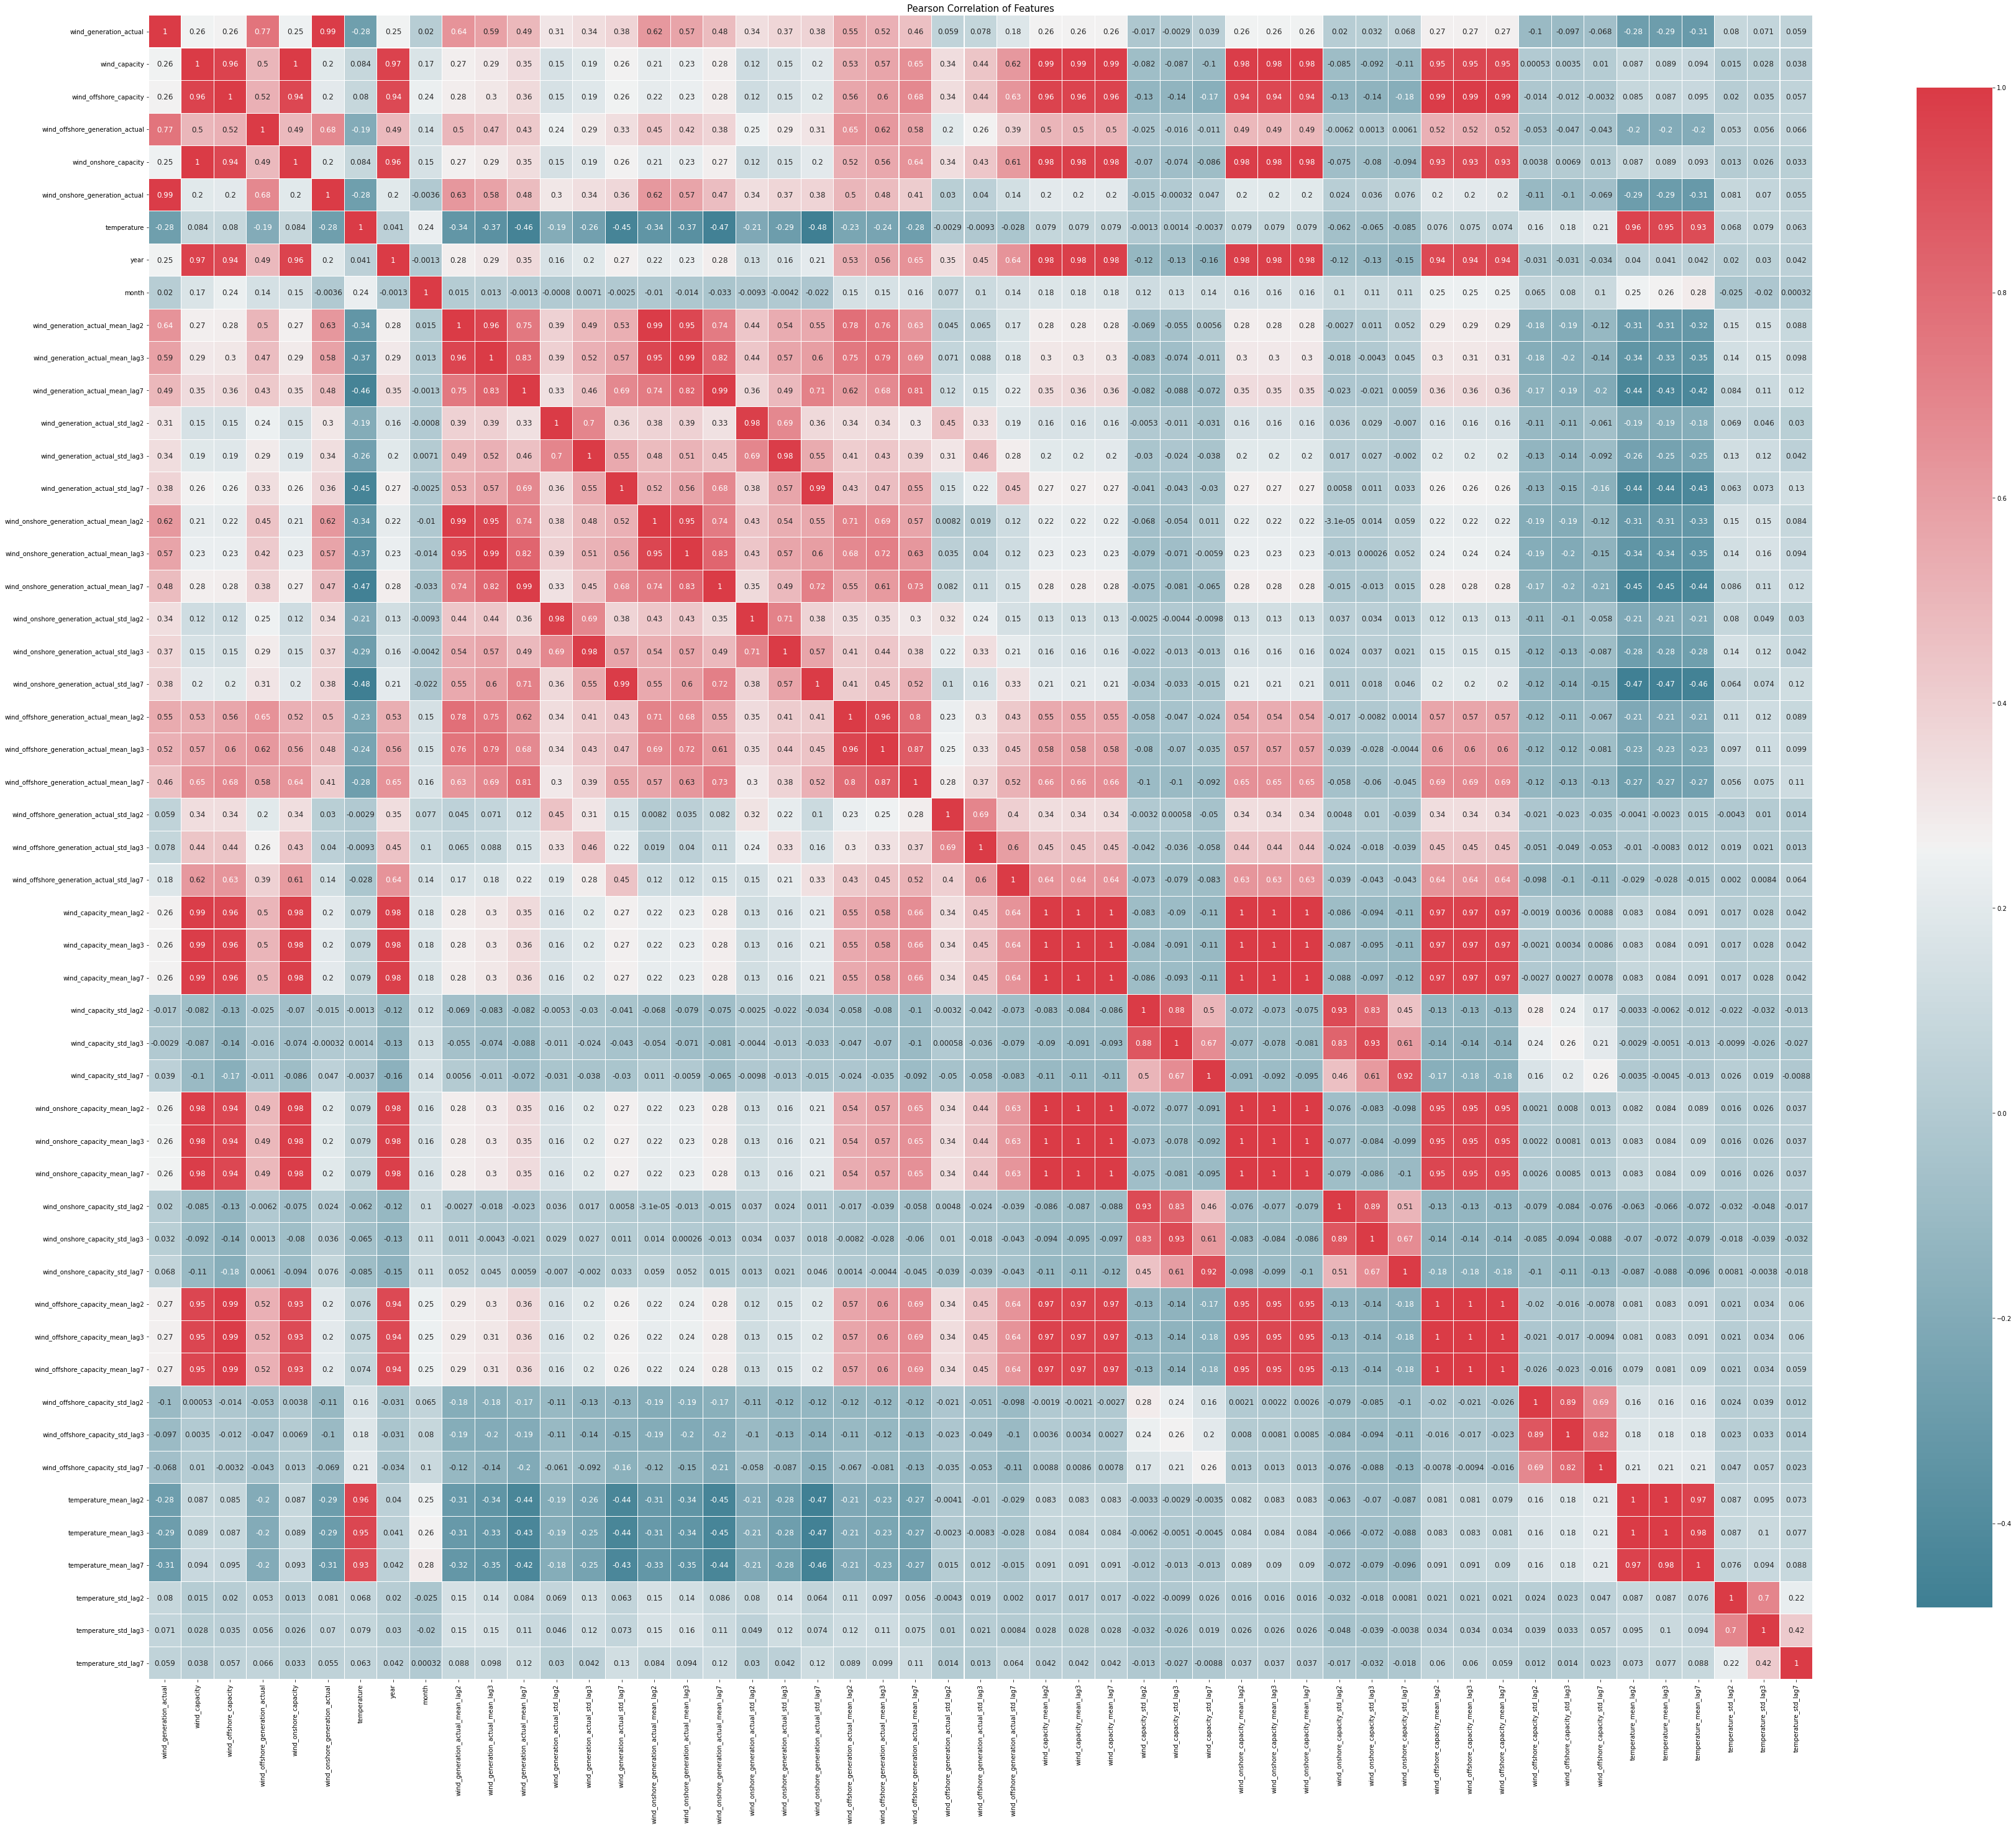

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(60, 50))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)


In [ ]:
data

utc_timestamp  wind_generation_actual  wind_capacity  \
0    2014-12-31 00:00:00+00:00                     0.0   27913.000000   
1    2015-01-01 00:00:00+00:00                325165.0   27913.541667   
2    2015-01-02 00:00:00+00:00                603554.0   27926.000000   
3    2015-01-03 00:00:00+00:00                462955.0   27926.000000   
4    2015-01-04 00:00:00+00:00                385023.0   27926.541667   
...                        ...                     ...            ...   
1822 2019-12-27 00:00:00+00:00                146590.0   50427.000000   
1823 2019-12-28 00:00:00+00:00                159126.0   50427.291667   
1824 2019-12-29 00:00:00+00:00                349839.0   50434.750000   
1825 2019-12-30 00:00:00+00:00                669271.0   50452.000000   
1826 2019-12-31 00:00:00+00:00                425225.0       0.000000   

      wind_offshore_capacity  wind_offshore_generation_actual  \
0                 667.000000                              0.0   
1                 667.000000                          12297.0   
2                 667.000000                          10533.0   
3                 667.000000                          12125.0   
4                 667.125000                          11500.0   
...                      ...                              ...   
1822             5735.000000                          40135.0   
1823             5735.291667                          66626.0   
1824             5742.000000                         121886.0   
1825             5742.000000                         133426.0   
1826                0.000000                          81593.0   

      wind_onshore_capacity  wind_onshore_generation_actual  temperature  \
0              27246.000000                             0.0    -0.057542   
1              27246.541667                        312868.0    -0.295958   
2              27259.000000                        593022.0     1.619958   
3              27259.000000                        450829.0     0.851458   
4              27259.375000                        373525.0     0.493625   
...                     ...                             ...          ...   
1822           44692.000000                        106453.0     1.327167   
1823           44692.000000                         92505.0    -1.441167   
1824           44692.750000                        227954.0    -1.314500   
1825           44710.000000                        535847.0     0.510208   
1826               0.000000                        343630.0     1.418833   

      year  month  ...  wind_offshore_capacity_mean_lag7  \
0     2014     12  ...                       3251.386822   
1     2015      1  ...                        667.000000   
2     2015      1  ...                        667.000000   
3     2015      1  ...                        667.000000   
4     2015      1  ...                        667.000000   
...    ...    ...  ...                               ...   
1822  2019     12  ...                       5733.321429   
1823  2019     12  ...                       5734.178571   
1824  2019     12  ...                       5735.041667   
1825  2019     12  ...                       5736.041667   
1826  2019     12  ...                       5737.041667   

      wind_offshore_capacity_std_lag2  wind_offshore_capacity_std_lag3  \
0                            1.966406                         2.927939   
1                            1.966406                         2.927939   
2                            0.000000                         0.000000   
3                            0.000000                         0.000000   
4                            0.000000                         0.000000   
...                               ...                              ...   
1822                         0.000190                         0.000000   
1823                         0.000190                         0.000000   
1824                         0.206240                      

# Pearson Correlation of Close relation Features

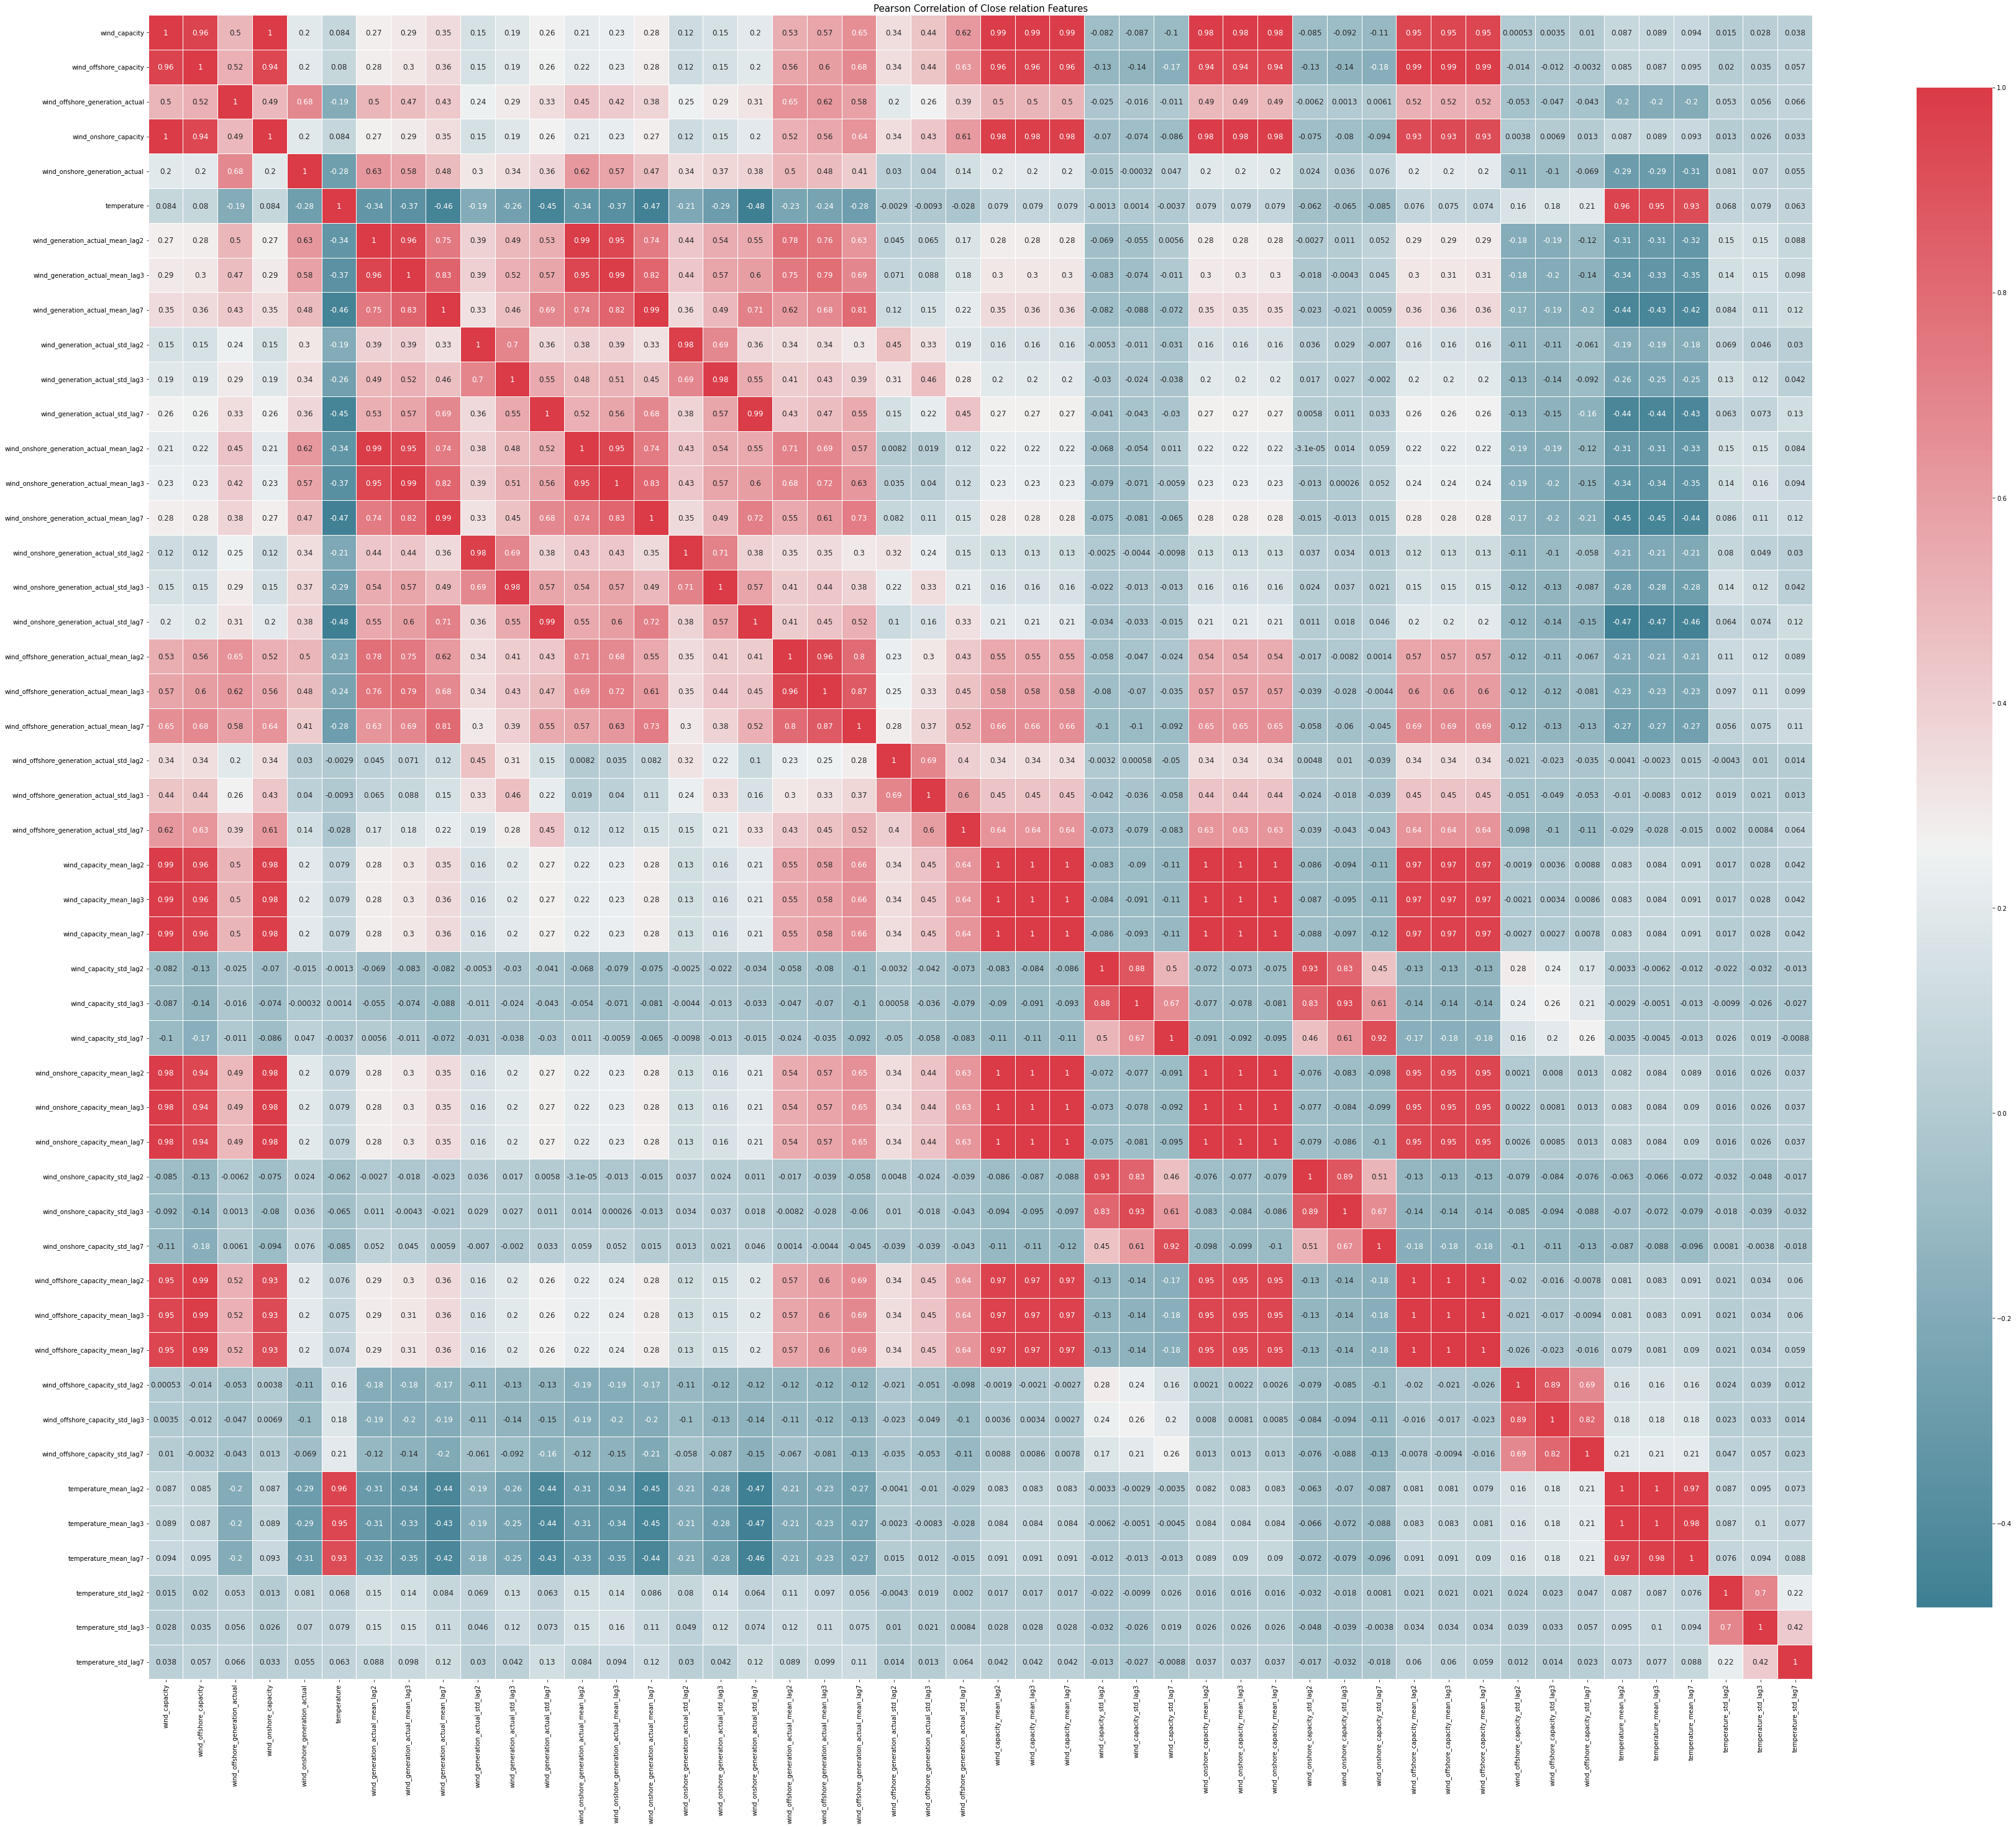

In [ ]:
data_x = data.copy()
data_x = data_x.drop(['wind_generation_actual',
       'utc_timestamp', 'year', 'month'],axis=1)


def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(60, 50))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Close relation Features', y=1.05, size=15)

correlation_heatmap(data_x)

split data into 
train and test 

# train being from 2017 to 2019 and test being from 2019 onwards

In [ ]:
train = data[data.year < 2018]
valid = data[data.year >= 2018]

In [ ]:
train.columns 

Index(['utc_timestamp', 'wind_generation_actual', 'wind_capacity',
       'wind_offshore_capacity', 'wind_offshore_generation_actual',
       'wind_onshore_capacity', 'wind_onshore_generation_actual',
       'temperature', 'year', 'month', 'wind_generation_actual_mean_lag2',
       'wind_generation_actual_mean_lag3', 'wind_generation_actual_mean_lag7',
       'wind_generation_actual_std_lag2', 'wind_generation_actual_std_lag3',
       'wind_generation_actual_std_lag7',
       'wind_onshore_generation_actual_mean_lag2',
       'wind_onshore_generation_actual_mean_lag3',
       'wind_onshore_generation_actual_mean_lag7',
       'wind_onshore_generation_actual_std_lag2',
       'wind_onshore_generation_actual_std_lag3',
       'wind_onshore_generation_actual_std_lag7',
       'wind_offshore_generation_actual_mean_lag2',
       'wind_offshore_generation_actual_mean_lag3',
       'wind_offshore_generation_actual_mean_lag7',
       'wind_offshore_generation_actual_std_lag2',
       'wind_off

the adfuller test is used to determine if time series is stationary or not, here we see that it's stationary

In [ ]:
result = adfuller(data["wind_generation_actual"])
print("wind_generation_actual")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

wind_generation_actual
ADF Statistic: -4.448569
p-value: 0.000243


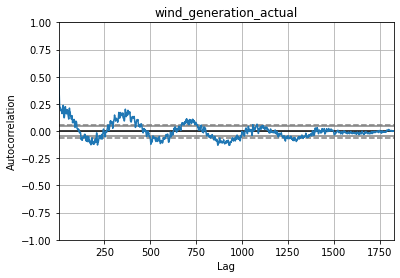

In [ ]:
# Autocorrelation graph
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data["wind_generation_actual"])
plt.title("wind_generation_actual")
plt.show()

Final Thoughts on Autocorrelation and Partial Autocorrelation

Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model”  mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q p AR model lags d differencing q MA lags

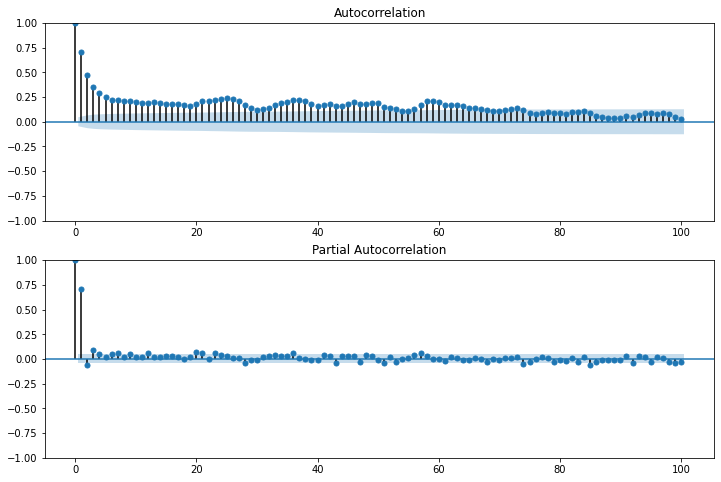

In [ ]:
#lets plot the graph to find the suitable value of P and Q
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data["wind_generation_actual"],lags=100,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data["wind_generation_actual"],lags=100,ax=ax2)
plt.show()

It gives us a p value which is exponential decrease till at what point=10,so (p=4)......
elect q value as 1 as there is suddent decrese in 1 (q=1)

# Fitting simple Arima Model

In [ ]:
# # p=4,d=0(as difference =0),q=1

#!pip install statsmodels.statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

 #lets fit our model

model=ARIMA(data["wind_generation_actual"],order=(4,0,1))
model_fit=model.fit()
print(model_fit.summary())



                                 SARIMAX Results                                  
Dep. Variable:     wind_generation_actual   No. Observations:                 1827
Model:                     ARIMA(4, 0, 1)   Log Likelihood              -24163.891
Date:                    Mon, 06 Jun 2022   AIC                          48341.781
Time:                            07:03:47   BIC                          48380.354
Sample:                                 0   HQIC                         48356.009
                                   - 1827                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.672e+05    5.2e-09   5.14e+13      0.000    2.67e+05    2.67e+05
ar.L1          1.6831      0.026     63.811      0.000       1.631       1.735
ar.L2         -0.822

# ARIMAX

In [ ]:
features = data_x.columns
arimaxmodel = auto_arima(train[features[1]],
                   exogenous = train[features], trace=True, 
                   error_action="ignore", suppress_warnings=True)
arimaxmodel.fit(train['wind_generation_actual'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23092.843, Time=6.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23100.831, Time=4.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23098.841, Time=4.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23098.784, Time=6.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23102.831, Time=4.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23114.381, Time=6.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23094.831, Time=6.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-23094.844, Time=6.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-23096.845, Time=6.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23096.803, Time=6.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23117.102, Time=5.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-23100.783, Time=6.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23100.840, Time=4.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-23096.831, Time=6.07 sec
 ARIM

In [ ]:
arimaxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1097
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7119.519
Date:                Mon, 06 Jun 2022   AIC                          14341.038
Time:                        07:05:42   BIC                          14596.008
Sample:                             0   HQIC                         14437.512
                               - 1097                                         
Covariance Type:                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
wind_capacity                                -3.4558     49.777     -0.069      0.945    -101.017      94.106
wind_offshore_capacity                        2.8056     50.447      0.056      0.956     -96.068     101.680
wind_offshore_generation_actual               1.0005      0.001    690.659      0.000       0.998       1.003
wind_onshore_capacity                         3.4220     49.745      0.069      0.945     -94.077     100.921
wind_onshore_generation_actual                1.0000      0.000   4242.935      0.000       1.000       1.000
temperature                                   0.3520     13.504      0.026      0.979     -26.116      26.820
wind_generation_actual_mean_lag2             -0.4945      0.078     -6.369      0.000      -0.647      -0.342
wind_generation_actual_mean_lag3             -0.7197      0.087     -8.243      0.000      -0.891      -0.549
wind_generation_actual_mean_lag7             -1.7807      0.168    -10.607      0.000      -2.110      -1.452
wind_generation_actual_std_lag2               0.0008      0.003      0.290      0.772      -0.004       0.006
wind_generation_actual_std_lag3               0.0009      0.005      0.202      0.840      -0.008       0.010
wind_generation_actual_std_lag7               0.0006      0.013      0.045      0.964      -0.024       0.025
wind_onshore_generation_actual_mean_lag2      0.4944      0.078      6.374      0.000       0.342       0.646
wind_onshore_generation_actual_mean_lag3      0.7198      0.087      8.268      0.000       0.549       0.890
wind_onshore_generation_actual_mean_lag7      1.7804      0.168     10.602      0.000       1.451       2.110
wind_onshore_generation_actual_std_lag2      -0.0009      0.003     -0.319      0.750      -0.006       0.005
wind_onshore_generation_actual_std_lag3      -0.0011      0.005     -0.232      0.817      -0.010       0.008
wind_onshore_generation_actual_std_lag7      -0.0007      0.013     -0.052      0.959      -0.026       0.024
wind_offshore_generation_actual_mean_lag2     0.4942      0.079      6.292      0.000       0.340       0.648
wind_offshore_generation_actual_mean_lag3     0.7190      0.090      8.022      0.000       0.543       0.895
wind_offshore_generation_actual_mean_lag7     1.7829      0.168     10.622      0.000       1.454       2.112
wind_offshore_generation_actual_std_lag2      0.0005      0.003      0.134      0.894      -0.006       0.007
wind_offshore_generation_actual_std_lag3     -0.0013      0.006     -0.230      0.818      -0.012       0.010
wind_offshore_generation_actual_std_lag7     -0.0015      0.015     -0.095      0.925      -0.032       0.029
wind_capacity_mean_lag2                     -17.4526     85.844     -0.203      0.839    -185.704     150.799
wind_capacity_mean_lag3                      46.1361     84.705      0.545      0.586    -119.883     212.155
wind_capacity_mean_lag7                      18.722

Text(0.5, 1.0, 'The change wind by the years')

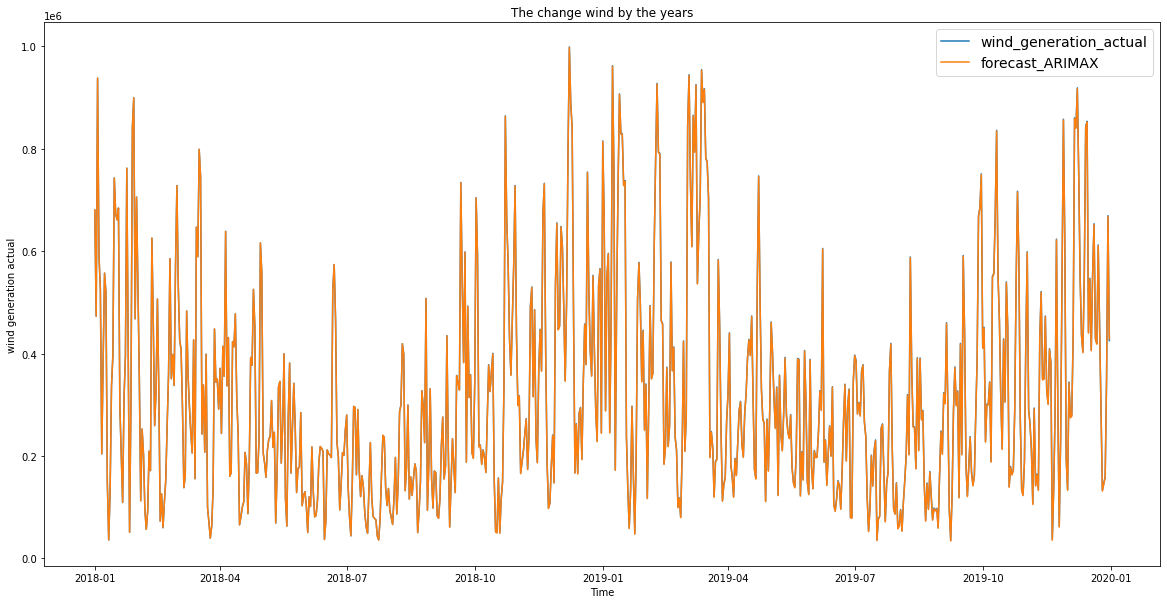

In [ ]:
#valid[["wind_generation_actual", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
# valid[["wind_generation_actual", "Forecast_ARIMAX"]].plot(figsize=(25, 7))
# plt.figure(figsize=(20,7))

# sns.lineplot(data=valid, x="utc_timestamp",y="wind_generation_actual")
# plt.xlabel("Time")
# plt.ylabel("wind generation actual")
# plt.title("The change wind by the years")

valid[["wind_generation_actual", "Forecast_ARIMAX"]]
plt.figure(figsize=(20,10))
actual=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
pred=plt.plot(valid['utc_timestamp'],valid['Forecast_ARIMAX'])
plt.legend(labels =['wind_generation_actual','forecast_ARIMAX'], fontsize=14)
plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")


In [ ]:
arimax_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_ARIMAX))
arimax_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_ARIMAX)

print("RMSE of Auto ARIMAX:", arimax_rmse)
print("\nMAE of Auto ARIMAX:", arimax_mae)

RMSE of Auto ARIMAX: 1036.006493309331

MAE of Auto ARIMAX: 843.3494668387602


In [ ]:
new_df = train.utc_timestamp

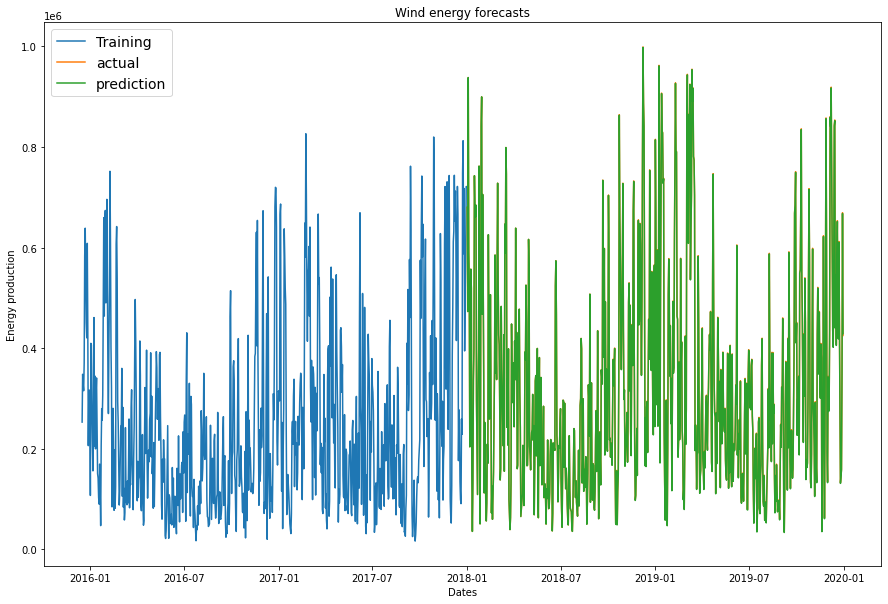

In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, arimaxforecast,label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()

fig, axes = plt.subplots(figsize=(15, 10))

yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
zv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'], arimaxforecast)
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
plt.legend(labels =['Training','actual','prediction'], fontsize=14)

# Decision Trees

In [ ]:
dtregressor = DecisionTreeRegressor()
dtregressor.fit(train[features], train['wind_generation_actual'])
dtforecast = dtregressor.predict(valid[features])
valid["Forecast_DT"] = dtforecast

Text(0.5, 1.0, 'The change wind by the years')

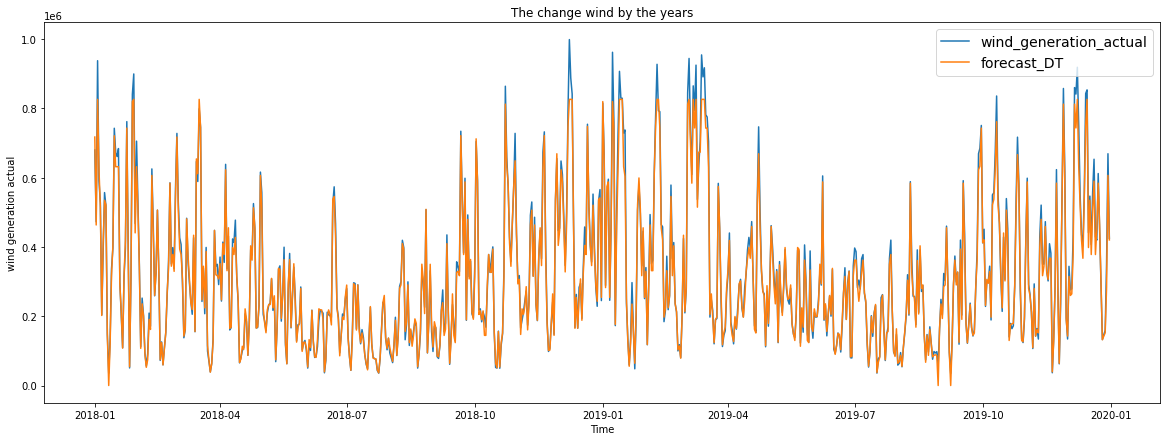

In [ ]:
# valid[["wind_generation_actual", "Forecast_DT"]].plot(figsize=(14, 7))

# ax.set(xlabel='x axis', ylabel='y axis')
# plt.show()

# valid.plot(xlabel='X Label', ylabel='Y Label', title='Plot Title')
valid[["wind_generation_actual", "Forecast_DT"]]
plt.figure(figsize=(20,7))
actual=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
pred=plt.plot(valid['utc_timestamp'],valid['Forecast_DT'])
plt.legend(labels =['wind_generation_actual','forecast_DT'], fontsize=14)
plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")

In [ ]:
dt_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_DT))
dt_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_DT)

print("RMSE of Decision Trees:", dt_rmse)
print("\nMAE of Decision Trees:", dt_mae)

RMSE of Decision Trees: 25825.17592243386

MAE of Decision Trees: 15684.276712328767


In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, dtforecast,label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()
yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'], dtforecast)
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend(labels =['Training','actual','prediction'], fontsize=14)

In [ ]:
# # using interactive graph - plotly 
# px.scatter_3d(valid, x="utc_timestamp",y="wind_generation_actual",z="Forecast_ARIMAX")

# Random Forest

In [ ]:
rfregressor = RandomForestRegressor()
rfregressor.fit(train[features], train['wind_generation_actual'])
rfforecast = rfregressor.predict(valid[features])
valid["Forecast_RF"] = rfforecast

Text(0.5, 1.0, 'The change wind by the years')

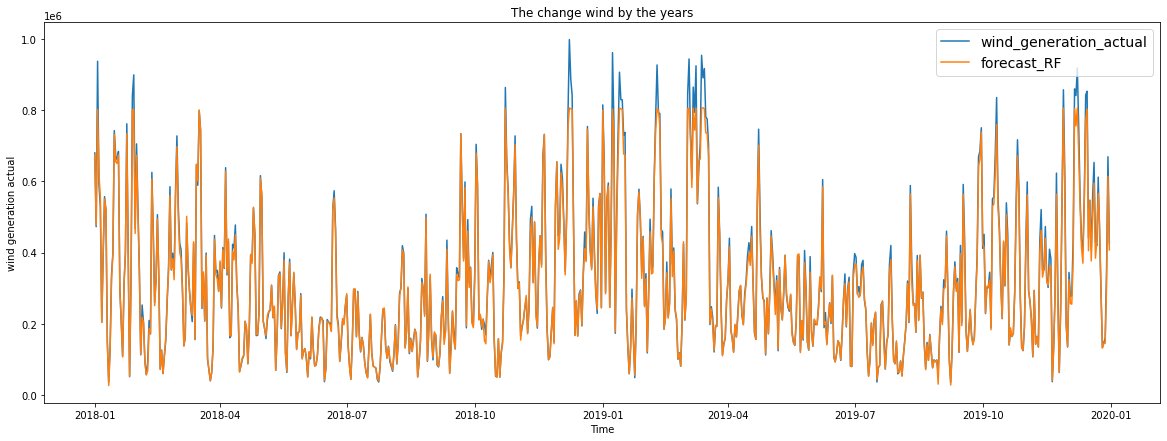

In [ ]:
# valid[["wind_generation_actual", "Forecast_RF"]].plot(figsize=(14, 7))
valid[["wind_generation_actual", "Forecast_RF"]]
plt.figure(figsize=(20,7))

actual=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
pred=plt.plot(valid['utc_timestamp'],valid['Forecast_RF'])
plt.legend(labels =['wind_generation_actual','forecast_RF'], fontsize=14)
plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")

In [ ]:
rf_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_RF))
rf_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_RF)

print("RMSE of Random Forests:", rf_rmse)
print("\nMAE of Random Forests:", rf_mae)

RMSE of Random Forests: 24174.15057031964

MAE of Random Forests: 12470.618260273972


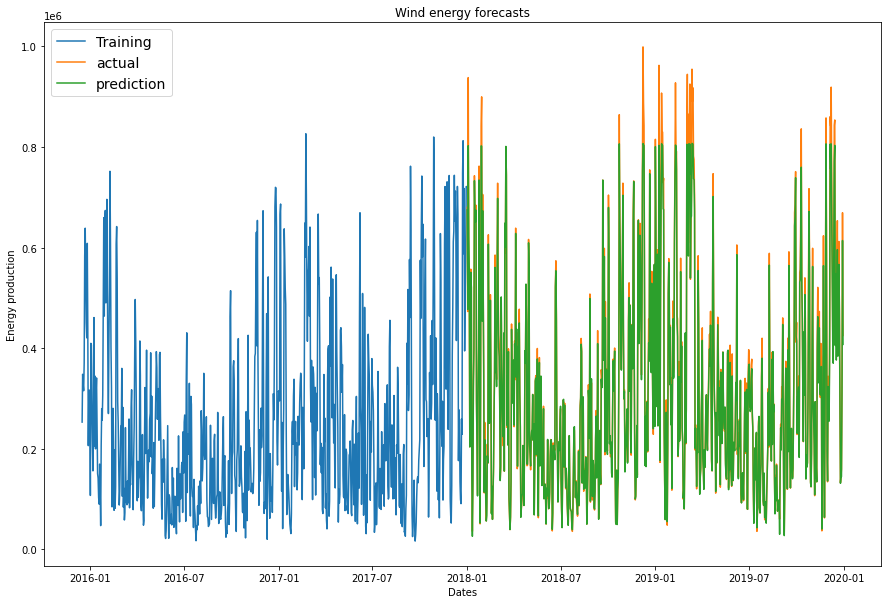

In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, rfforecast,label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()

fig, axes = plt.subplots(figsize=(15, 10))

yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'], rfforecast)
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend(labels =['Training','actual','prediction'], fontsize=14)

# Support Vector Machine

In [ ]:
svmregressor = SVR()
svmregressor.fit(train[features], train['wind_generation_actual'])
svmforecast = svmregressor.predict(valid[features])
valid["Forecast_SVM"] = svmforecast

Text(0.5, 1.0, 'The change wind by the years')

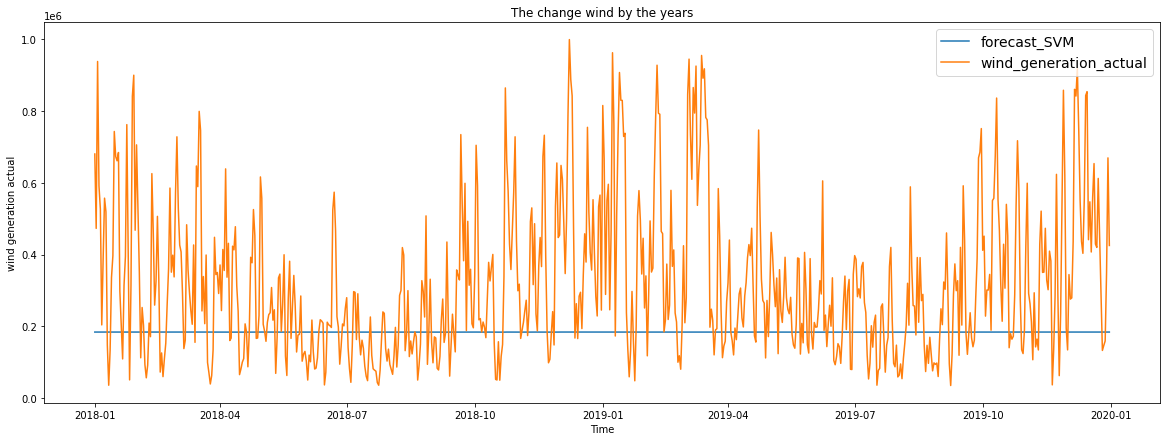

In [ ]:
# valid[["wind_generation_actual", "Forecast_SVM"]].plot(figsize=(14, 7))

valid[["wind_generation_actual", "Forecast_SVM"]]
plt.figure(figsize=(20,7))
actual=plt.plot(valid['utc_timestamp'],valid['Forecast_SVM'])
pred=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
plt.legend(labels =['forecast_SVM','wind_generation_actual'], fontsize=14)
plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")

In [ ]:
svm_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_SVM))
svm_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_SVM)

print("RMSE of SVM:", svm_rmse)
print("\nMAE of SVM:", svm_mae)

RMSE of SVM: 248742.31208116908

MAE of SVM: 174588.94534201725


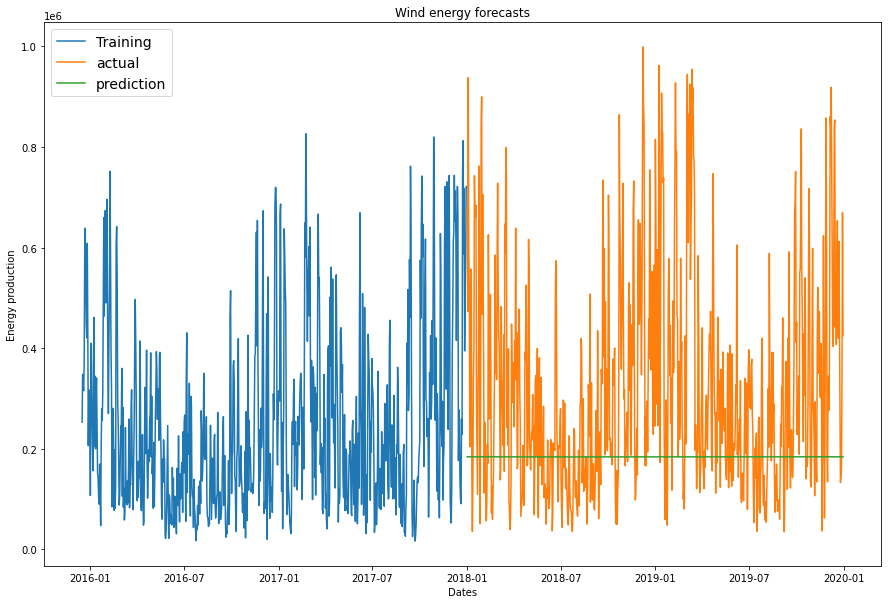

In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, svmforecast,label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()
fig, axes = plt.subplots(figsize=(15, 10))

yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'], svmforecast)
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend(labels =['Training','actual','prediction'], fontsize=14)

# Artificial Neural Network

In [ ]:
X_train, X_valid, Y_train, Y_valid=train[features], valid[features], train["wind_generation_actual"], valid["wind_generation_actual"]
X_train, X_valid = np.array(X_train), np.array(X_valid)

X_train_array = np.asarray(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])))
X_valid_array = np.asarray(X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1]))
Y_train_array = np.asarray(Y_train) 
Y_valid_array = np.asarray(Y_valid)

In [ ]:
X_train.shape

(1097, 48)

In [ ]:
X_valid_array.shape

(730, 1, 48)

In [ ]:
ann_model = Sequential([
    Dense(32, activation="relu", input_shape=(1, X_train_array.shape[2])),
    Dense(8, activation="relu"),
    Dense(1)
    ])

In [ ]:
ann_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
history = ann_model.fit(X_train_array, Y_train_array, 
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=1, batch_size = 128)

Epoch 1/150
9/9 [==============================] - 1s 28ms/step - loss: 48854364160.0000 - root_mean_squared_error: 221030.2344 - val_loss: 53082451968.0000 - val_root_mean_squared_error: 230396.2969
Epoch 2/150
9/9 [==============================] - 0s 6ms/step - loss: 24922671104.0000 - root_mean_squared_error: 157869.1562 - val_loss: 26314205184.0000 - val_root_mean_squared_error: 162216.5312
Epoch 3/150
9/9 [==============================] - 0s 6ms/step - loss: 14104242176.0000 - root_mean_squared_error: 118761.2812 - val_loss: 17817229312.0000 - val_root_mean_squared_error: 133481.1875
Epoch 4/150
9/9 [==============================] - 0s 6ms/step - loss: 11562052608.0000 - root_mean_squared_error: 107526.9844 - val_loss: 17892921344.0000 - val_root_mean_squared_error: 133764.4219
Epoch 5/150
9/9 [==============================] - 0s 7ms/step - loss: 10897079296.0000 - root_mean_squared_error: 104389.0781 - val_loss: 15775793152.0000 - val_root_mean_squared_error: 125601.7266
Epoc

In [ ]:
annforecast = ann_model.predict(X_valid_array)
valid["Forecast_ANN"] = annforecast.squeeze()

Text(0.5, 1.0, 'The change wind by the years')

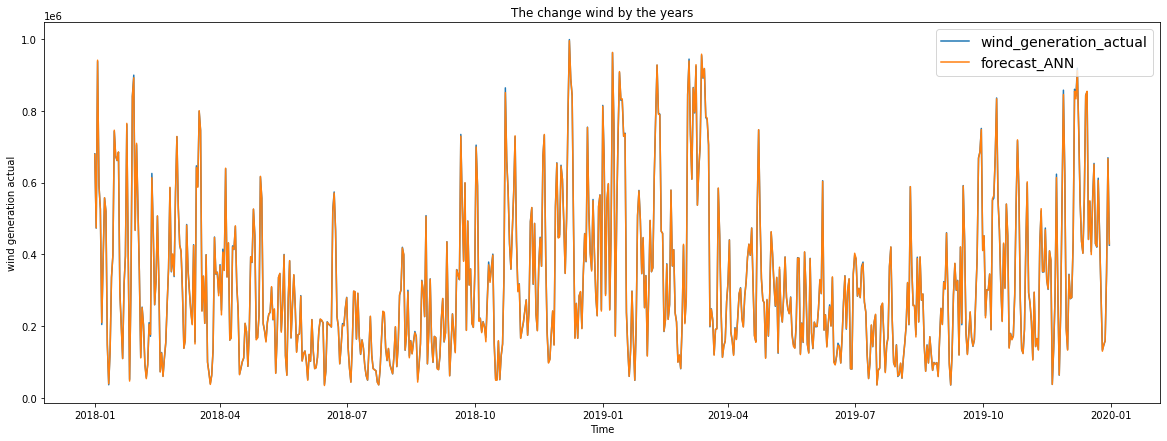

In [ ]:
# valid[["wind_generation_actual", "Forecast_ANN"]].plot(figsize=(14, 7))
valid[["wind_generation_actual", "Forecast_ANN"]]
plt.figure(figsize=(20,7))
actual=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
pred=plt.plot(valid['utc_timestamp'],valid['Forecast_ANN'])

plt.legend(labels =['wind_generation_actual','forecast_ANN'], fontsize=14)
plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")

In [ ]:
ann_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_ANN))
ann_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_ANN)

print("RMSE of ANN:", ann_rmse)
print("\nMAE of ANN:", ann_mae)

RMSE of ANN: 2465.5239673557217

MAE of ANN: 1670.1253745719177


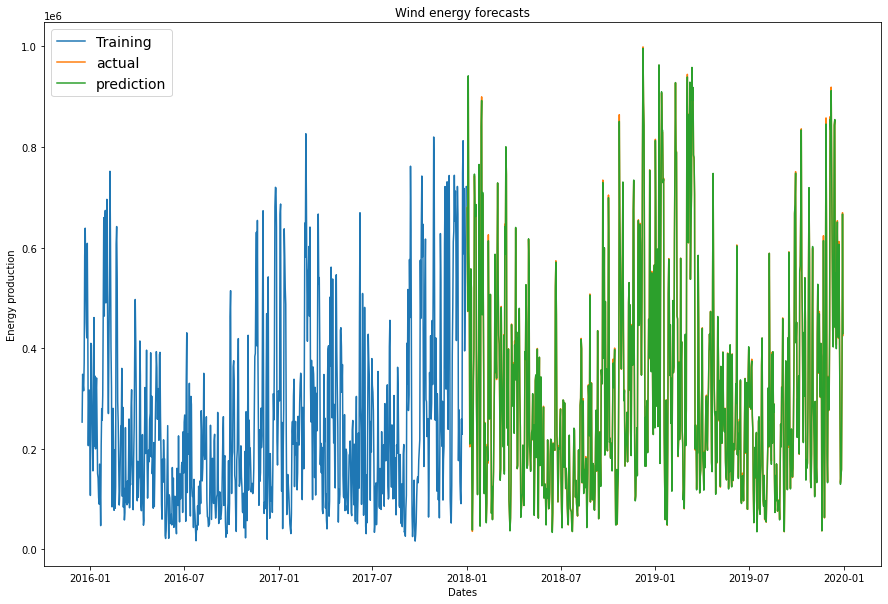

In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, annforecast.squeeze(), label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()
fig, axes = plt.subplots(figsize=(15, 10))

yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'],  annforecast.squeeze())
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend(labels =['Training','actual','prediction'], fontsize=14)

# Recurrent Neural Network

In [ ]:
rnn_model = Sequential([
    SimpleRNN(50, activation = "relu", return_sequences=False, input_shape=(1, X_train_array.shape[2])),
    Dense(8, activation="relu"),
    Dense(1)

    ])
rnn_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
history = rnn_model.fit(X_train_array, Y_train_array, 
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=2, batch_size = 128)

Epoch 1/150
9/9 - 1s - loss: 53018402816.0000 - root_mean_squared_error: 230257.2500 - val_loss: 65153433600.0000 - val_root_mean_squared_error: 255251.7031
Epoch 2/150
9/9 - 0s - loss: 26834737152.0000 - root_mean_squared_error: 163813.1094 - val_loss: 30107920384.0000 - val_root_mean_squared_error: 173516.3438
Epoch 3/150
9/9 - 0s - loss: 14539657216.0000 - root_mean_squared_error: 120580.5000 - val_loss: 19025606656.0000 - val_root_mean_squared_error: 137933.3438
Epoch 4/150
9/9 - 0s - loss: 12426624000.0000 - root_mean_squared_error: 111474.7656 - val_loss: 16796972032.0000 - val_root_mean_squared_error: 129603.1328
Epoch 5/150
9/9 - 0s - loss: 10538437632.0000 - root_mean_squared_error: 102656.8906 - val_loss: 13358013440.0000 - val_root_mean_squared_error: 115576.8672
Epoch 6/150
9/9 - 0s - loss: 8024205312.0000 - root_mean_squared_error: 89577.9297 - val_loss: 10880281600.0000 - val_root_mean_squared_error: 104308.5859
Epoch 7/150
9/9 - 0s - loss: 6181258752.0000 - root_mean_squ

In [ ]:
rnnforecast = rnn_model.predict(X_valid_array)
valid["Forecast_RNN"] = rnnforecast

Text(0.5, 1.0, 'The change wind by the years')

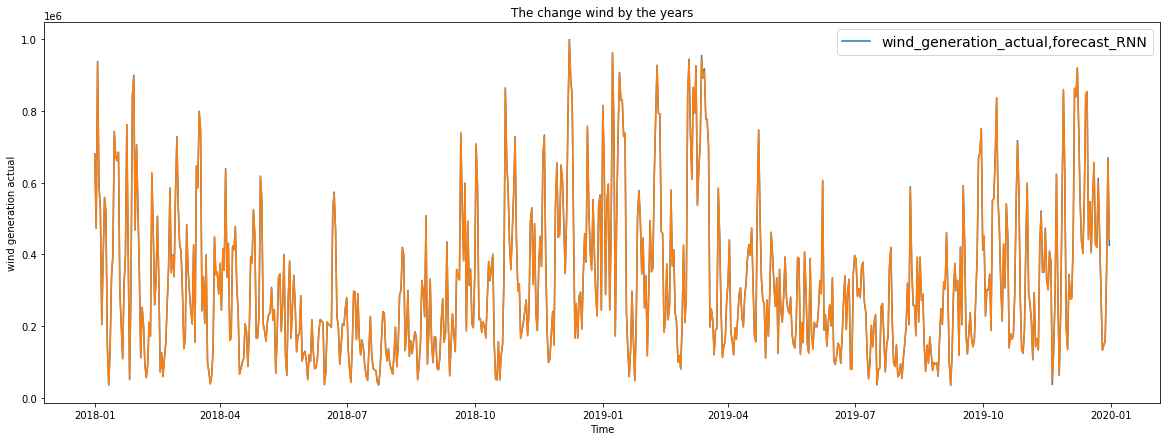

In [ ]:
# valid[["wind_generation_actual", "Forecast_RNN"]].plot(figsize=(14, 7))
valid[["wind_generation_actual", "Forecast_RNN"]]
plt.figure(figsize=(20,7))

actual=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
pred=plt.plot(valid['utc_timestamp'],valid['Forecast_RNN'])
plt.legend(labels =['wind_generation_actual,''forecast_RNN'], fontsize=14)
plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")

In [ ]:
rnn_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_RNN))
rnn_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_RNN)

print("RMSE of RNN:", rnn_rmse)
print("\nMAE of RNN:", rnn_mae)

RMSE of RNN: 1715.7976673396668

MAE of RNN: 1161.5332138270549


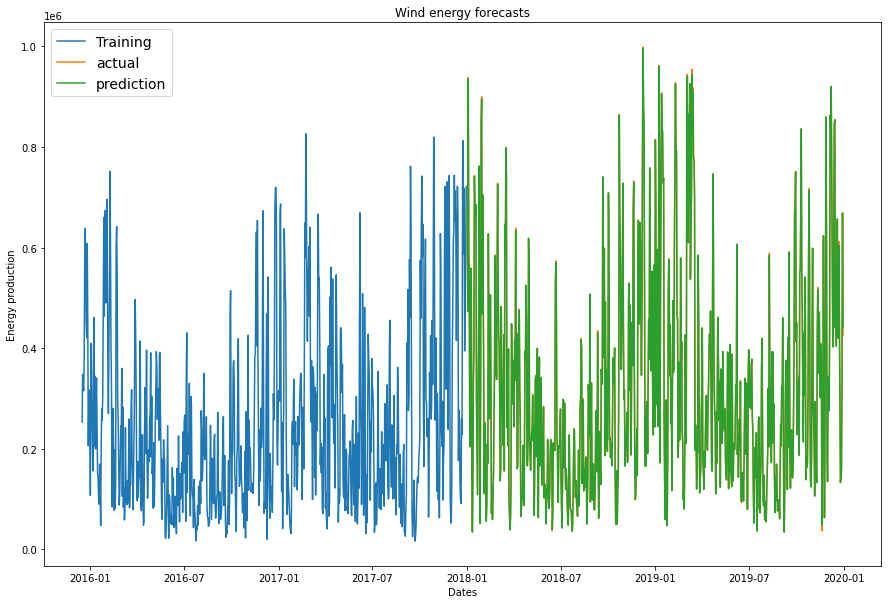

In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, rnnforecast,label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()

fig, axes = plt.subplots(figsize=(15, 10))

yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'], rnnforecast)
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend(labels =['Training','actual','prediction'], fontsize=14)

# LSTM

In [ ]:
lstm_model = Sequential([
    Bidirectional(LSTM(100, activation = "relu", return_sequences=False, input_shape=(1, X_train_array.shape[2]))),
    Dense(8, activation="relu"),
    Dense(1)

    ])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
history = lstm_model.fit(X_train_array, Y_train_array, 
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=2, batch_size = 128)

Epoch 1/150
9/9 - 3s - loss: 55529660416.0000 - root_mean_squared_error: 235647.3125 - val_loss: 66619215872.0000 - val_root_mean_squared_error: 258106.9844
Epoch 2/150
9/9 - 0s - loss: 29111701504.0000 - root_mean_squared_error: 170621.5156 - val_loss: 30283638784.0000 - val_root_mean_squared_error: 174021.9531
Epoch 3/150
9/9 - 0s - loss: 16175556608.0000 - root_mean_squared_error: 127183.1641 - val_loss: 20860542976.0000 - val_root_mean_squared_error: 144431.7969
Epoch 4/150
9/9 - 0s - loss: 13942276096.0000 - root_mean_squared_error: 118077.4141 - val_loss: 16422886400.0000 - val_root_mean_squared_error: 128151.8047
Epoch 5/150
9/9 - 0s - loss: 10113027072.0000 - root_mean_squared_error: 100563.5469 - val_loss: 12210113536.0000 - val_root_mean_squared_error: 110499.3828
Epoch 6/150
9/9 - 0s - loss: 7720613888.0000 - root_mean_squared_error: 87867.0234 - val_loss: 10070010880.0000 - val_root_mean_squared_error: 100349.4453
Epoch 7/150
9/9 - 0s - loss: 5933107200.0000 - root_mean_squ

In [ ]:
lstmforecast = lstm_model.predict(X_valid_array)
valid["Forecast_LSTM"] = lstmforecast

Text(0.5, 1.0, 'The change wind by the years')

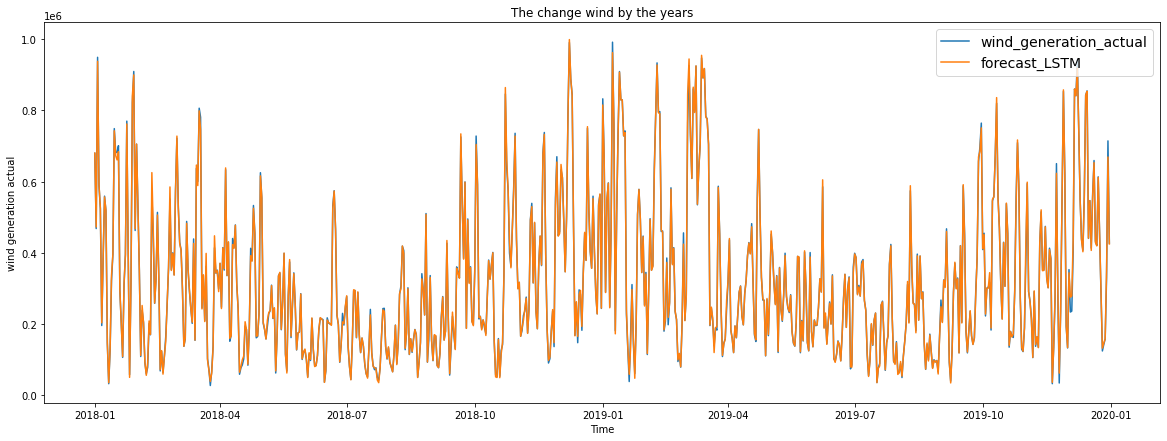

In [ ]:
# valid[["wind_generation_actual", "Forecast_LSTM"]].plot(figsize=(14, 7))
valid[["wind_generation_actual", "Forecast_LSTM"]]
plt.figure(figsize=(20,7))
pred=plt.plot(valid['utc_timestamp'],valid['Forecast_LSTM'])
actual=plt.plot(valid['utc_timestamp'],valid['wind_generation_actual'])
plt.legend(labels =['wind_generation_actual','forecast_LSTM'], fontsize=14)

plt.xlabel("Time")
plt.ylabel("wind generation actual")
plt.title("The change wind by the years")

In [ ]:
lstm_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_LSTM))
lstm_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_LSTM)

print("RMSE of LSTM:", lstm_rmse)
print("\nMAE of LSTM:", lstm_mae)

RMSE of LSTM: 8756.21594989744

MAE of LSTM: 4719.887775577911


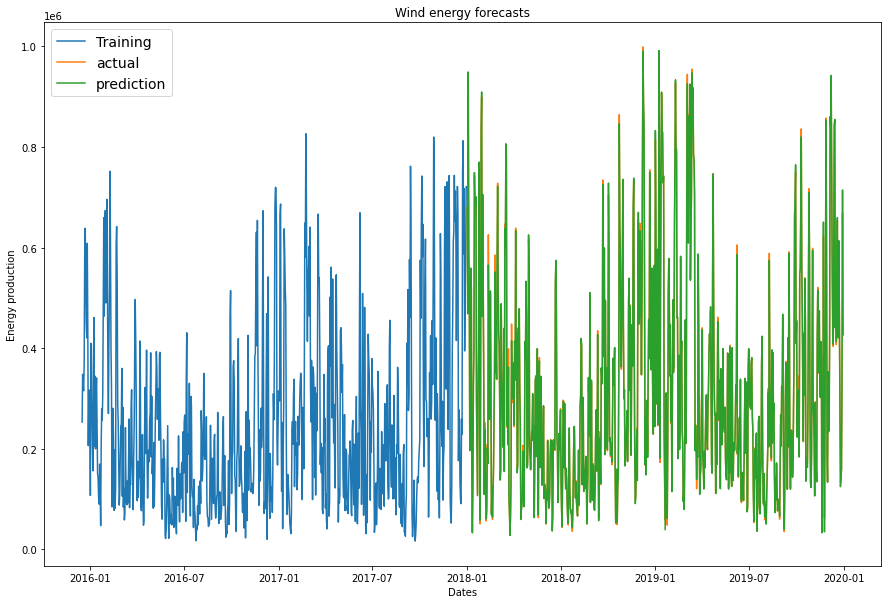

In [ ]:
# fig, axes = plt.subplots(figsize=(15, 10))

# axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
# axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
# axes.plot(valid.index, lstmforecast,label='Predicted Values')
# axes.set_title('Wind energy forecasts')
# axes.set_xlabel('Dates')
# axes.set_ylabel('Energy production')
# axes.legend()
fig, axes = plt.subplots(figsize=(15, 10))


yx=axes.plot(new_df.iloc[350:],train.iloc[350:]["wind_generation_actual"])
xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
u=axes.plot(valid['utc_timestamp'], lstmforecast)

axes.set_title('Wind energy forecasts')

axes.set_xlabel('Dates')

axes.set_ylabel('Energy production')
axes.legend(labels =['Training','actual','prediction'], fontsize=14)

# Conclusion

In [ ]:

metrics = {'Models' : ['ARIMAX', 'Decision Trees', 'Random Forest', 'SVM', 'ANN', 'RNN', 'LSTM'],
           'RMSE'   : [arimax_rmse, dt_rmse, rf_rmse, svm_rmse, ann_rmse, rnn_rmse, lstm_rmse],
           'MAE'    : [arimax_mae, dt_mae, rf_mae, svm_mae, ann_mae, rnn_mae, lstm_mae],
           'NRMSE'  : [arimax_rmse/valid.Forecast_ARIMAX.mean(), dt_rmse/valid.Forecast_DT.mean(), 
                       rf_rmse/valid.Forecast_RF.mean(), svm_rmse/valid.Forecast_SVM.mean(),
                       ann_rmse/valid.Forecast_ANN.mean(), rnn_rmse/valid.Forecast_RNN.mean(),
                       lstm_rmse/valid.Forecast_LSTM.mean()]}
metrics = pd.DataFrame(metrics)

In [ ]:
metrics.sort_values(by = 'RMSE')

Models           RMSE            MAE     NRMSE
0          ARIMAX    1036.006493     843.349467  0.003263
5             RNN    1715.797667    1161.533214  0.005394
4             ANN    2465.523967    1670.125375  0.007760
6            LSTM    8756.215950    4719.887776  0.027519
2   Random Forest   24174.150570   12470.618260  0.078347
1  Decision Trees   25825.175922   15684.276712  0.083542
3             SVM  248742.312081  174588.945342  1.352823

In [ ]:
metrics.sort_values(by = 'MAE')

Models           RMSE            MAE     NRMSE
0          ARIMAX    1036.006493     843.349467  0.003263
5             RNN    1715.797667    1161.533214  0.005394
4             ANN    2465.523967    1670.125375  0.007760
6            LSTM    8756.215950    4719.887776  0.027519
2   Random Forest   24174.150570   12470.618260  0.078347
1  Decision Trees   25825.175922   15684.276712  0.083542
3             SVM  248742.312081  174588.945342  1.352823

comparison for best models

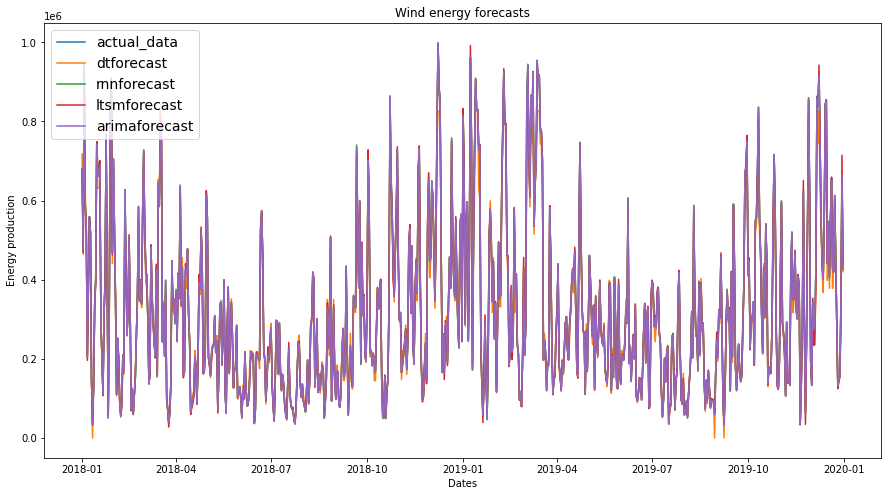

In [ ]:
fig, axes = plt.subplots(figsize=(15, 8))

xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
m1=axes.plot(valid['utc_timestamp'], dtforecast)
m2=axes.plot(valid['utc_timestamp'], rnnforecast)
m3=axes.plot(valid['utc_timestamp'], lstmforecast)
m4=axes.plot(valid['utc_timestamp'], arimaxforecast)


axes.set_title('Wind energy forecasts')

axes.set_xlabel('Dates')

axes.set_ylabel('Energy production')
axes.legend(labels =['actual_data','dtforecast','rnnforecast','ltsmforecast','arimaforecast'], fontsize=14)

comparison of rnn and ann<br>
we compared this two models beacuse both this models are neural nertwork models

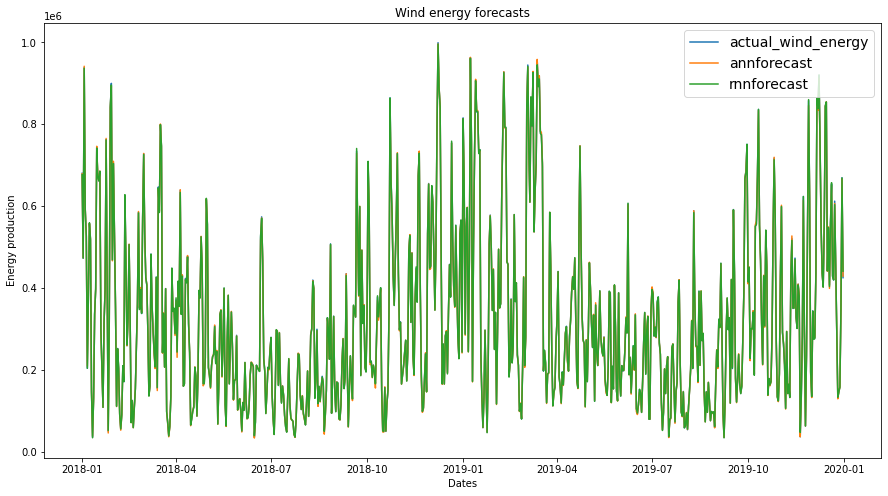

In [ ]:
fig, axes = plt.subplots(figsize=(15, 8))

xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
m1=axes.plot(valid['utc_timestamp'], annforecast.squeeze())
m2=axes.plot(valid['utc_timestamp'], rnnforecast)

axes.set_title('Wind energy forecasts')

axes.set_xlabel('Dates')

axes.set_ylabel('Energy production')
axes.legend(labels =['actual_wind_energy','annforecast','rnnforecast',], fontsize=14)

comparison between random forest and svm <br>
Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problem you will need to reduce it into multiple binary classification problems.


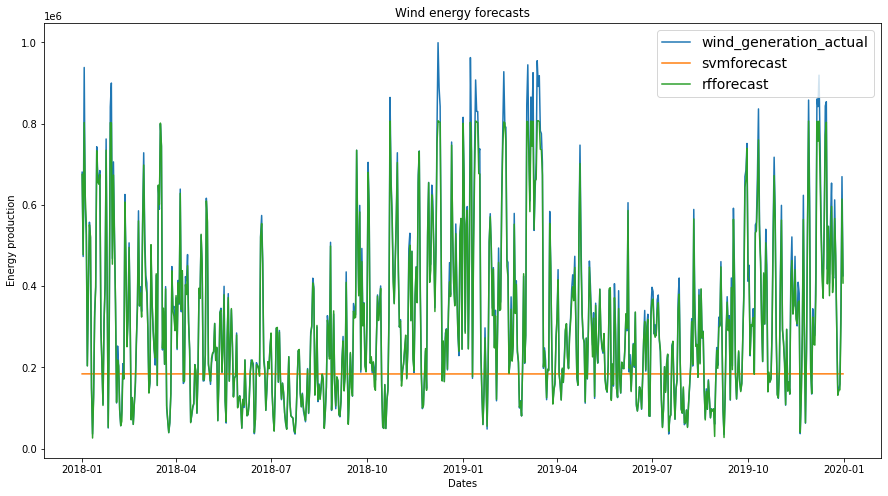

In [ ]:
fig, axes = plt.subplots(figsize=(15, 8))

xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
m1=axes.plot(valid['utc_timestamp'], svmforecast)
m4=axes.plot(valid['utc_timestamp'], rfforecast)
axes.set_title('Wind energy forecasts')

axes.set_xlabel('Dates')

axes.set_ylabel('Energy production')
axes.legend(labels =['wind_generation_actual','svmforecast','rfforecast'], fontsize=14)

comparison of low score models
here we are comparing models which having low scores


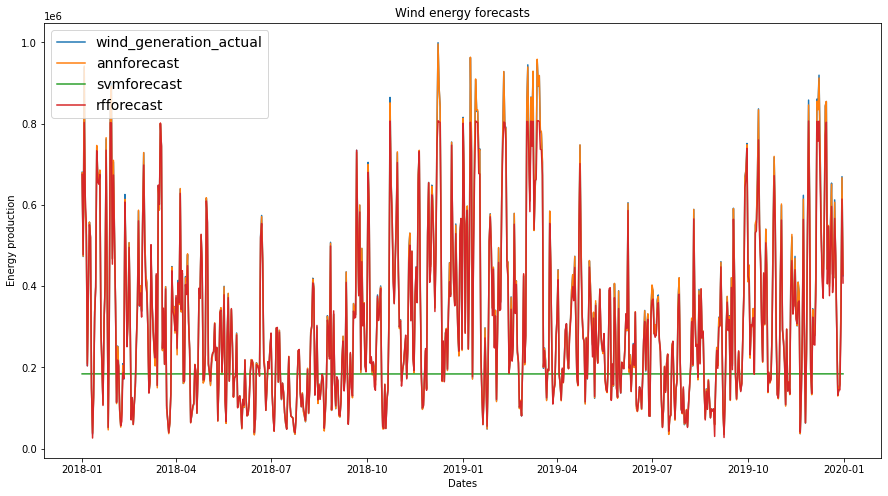

In [ ]:
fig, axes = plt.subplots(figsize=(15, 8))

xv=axes.plot(valid['utc_timestamp'], valid["wind_generation_actual"])
m1=axes.plot(valid['utc_timestamp'], annforecast.squeeze())
m6 = axes.plot(valid['utc_timestamp'], svmforecast)
m4=axes.plot(valid['utc_timestamp'], rfforecast)
axes.set_title('Wind energy forecasts')

axes.set_xlabel('Dates')

axes.set_ylabel('Energy production')
axes.legend(labels =['wind_generation_actual','annforecast','svmforecast','rfforecast'], fontsize=14)